In [1]:
import pandas_datareader as web
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize
from scipy.stats import norm
import numpy_financial as npf
import requests

In [2]:

def generate_df(file_name):
    df = pd.read_csv(f"./data/coincodex2/{file_name}")
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date',inplace=True)
    df = df.iloc[::-1]
    df = df[df.index >= datetime(2020,12,1)]
    df.head()
    return df

In [3]:
# https://21shares.com/product/hodl/
btc_df = generate_df("bitcoin_2020-12-1_2022-5-10.csv")
eth_df = generate_df("ethereum_2020-12-1_2022-5-10.csv")
sol_df = generate_df("solana_2020-12-1_2022-5-10.csv")
luna_df = generate_df("terra_2020-12-1_2022-5-10.csv")
dot_df = generate_df("polkadot_2020-12-1_2022-5-10.csv")
btc_df

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2020-12-01,19692.233922,19877.368317,18338.560347,18855.043740,6.865105e+10,3.574187e+11
2020-12-02,18756.509652,19330.508183,18356.075312,19201.276131,6.473617e+10,3.515834e+11
2020-12-03,19217.923079,19587.145690,18909.027573,19427.954960,4.546048e+10,3.575482e+11
2020-12-04,19430.848422,19510.639948,18643.370271,18737.192660,4.271185e+10,3.546535e+11
2020-12-05,18660.486213,19167.433321,18560.029883,19127.656824,4.349340e+10,3.523940e+11
...,...,...,...,...,...,...
2022-05-05,39690.031700,39793.917300,35756.460926,36568.759600,7.167143e+10,7.313246e+11
2022-05-06,36571.607200,36581.659680,35403.457407,36033.063400,8.464473e+10,6.881267e+11
2022-05-07,36019.555100,36121.832406,34857.250100,35552.564000,5.217910e+10,6.825999e+11


### Underlying Assets
* Cryptocurrency	Weighting	Quantity per ETP	Reference Price
* Bitcoin	51.09%	0.00016644 ($5.40)	$32460.80
* Ethereum	24.52%	0.00108719 ($2.59)	$2384.89
* Polkadot	15.08%	0.13503758 ($1.60)	$11.81
* Solana	5.14%	0.00766511 ($0.54)	$70.89
* Terra	4.18%	0.00751516 ($0.44)	$58.79 -->

In [4]:
principal_usd = 100000
coins = ['BTC','ETH','DOT','SOL','LUNA']
coin_allocations = [0.5109,0.2452,0.1508,0.0514,0.0418]
sum(coin_allocations)
coin_principals = [i*principal_usd for i in coin_allocations]
coin_principals
coin_init_amounts = []

In [5]:
hodl_portfolio_df = pd.concat([btc_df['Close'],eth_df['Close'],dot_df['Close'],sol_df['Close'],luna_df['Close']],axis=1)
hodl_portfolio_df.columns = coins
hodl_portfolio_df

,BTC,ETH,DOT,SOL,LUNA
Date,,,,,
2020-12-01,18855.043740,589.814467,5.094680,1.977516,0.388320
2020-12-02,19201.276131,598.357253,5.448876,2.112355,0.406310
2020-12-03,19427.954960,616.904853,5.413367,2.098405,0.506414
2020-12-04,18737.192660,571.978333,5.047263,1.856668,0.451015
2020-12-05,19127.656824,595.548506,5.186312,1.977440,0.509040
...,...,...,...,...,...
2022-05-05,36568.759600,2752.980400,14.590200,84.636600,82.625100
2022-05-06,36033.063400,2699.825200,14.315900,81.959800,77.418900
2022-05-07,35552.564000,2644.925800,13.801500,79.132500,68.488700


In [6]:
hodl_portfolio_df.mean()

BTC     44325.913196
ETH      2699.055034
DOT        25.395712
SOL        81.842117
LUNA       35.908220
dtype: float64

In [7]:
hodl_portfolio_df.cov()

,BTC,ETH,DOT,SOL,LUNA
BTC,1.084209e+08,6.816438e+06,106449.561758,358784.909834,65773.913160
ETH,6.816438e+06,1.034938e+06,6882.017701,62128.882569,19647.826071
DOT,1.064496e+05,6.882018e+03,120.591299,369.612875,25.008138
SOL,3.587849e+05,6.212888e+04,369.612875,4781.407262,1482.162286
LUNA,6.577391e+04,1.964783e+04,25.008138,1482.162286,1039.806699


In [8]:
hodl_portfolio_df.pct_change(1).mean()

BTC     0.001706
ETH     0.003887
DOT     0.003961
SOL     0.009705
LUNA    0.013301
dtype: float64

In [9]:
hodl_portfolio_df.pct_change(1).corr()

,BTC,ETH,DOT,SOL,LUNA
BTC,1.000000,0.786520,0.666685,0.447743,0.513097
ETH,0.786520,1.000000,0.713325,0.543105,0.497517
DOT,0.666685,0.713325,1.000000,0.459222,0.453718
SOL,0.447743,0.543105,0.459222,1.000000,0.477981
LUNA,0.513097,0.497517,0.453718,0.477981,1.000000


In [10]:
hodl_portfolio_log_returns_df = np.log(hodl_portfolio_df/hodl_portfolio_df.shift(1))
hodl_portfolio_log_returns_df.head()

,BTC,ETH,DOT,SOL,LUNA
Date,,,,,
2020-12-01,NaN,NaN,NaN,NaN,NaN
2020-12-02,0.018196,0.014380,0.067213,0.065962,0.045287
2020-12-03,0.011736,0.030527,-0.006538,-0.006626,0.220238
2020-12-04,-0.036203,-0.075614,-0.070025,-0.122394,-0.115854
2020-12-05,0.020625,0.040382,0.027177,0.063019,0.121027


In [11]:
hodl_portfolio_log_returns_df.mean()

BTC     0.000909
ETH     0.002562
DOT     0.001447
SOL     0.006634
LUNA    0.008541
dtype: float64

In [12]:
hodl_portfolio_log_returns_df.cov() * 365

,BTC,ETH,DOT,SOL,LUNA
BTC,0.581995,0.600454,0.712501,0.530689,0.736943
ETH,0.600454,0.969086,0.986563,0.839528,0.961653
DOT,0.712501,0.986563,1.830522,1.013616,1.246973
SOL,0.530689,0.839528,1.013616,2.215003,1.408529
LUNA,0.736943,0.961653,1.246973,1.408529,3.374072


In [13]:
BTC_ALLOC = coin_allocations[0]
BTC_NET_ALLOC_USD = (BTC_ALLOC * principal_usd)
BTC_INIT_AMNT = round(BTC_NET_ALLOC_USD / float(hodl_portfolio_df['BTC'].iloc[0]),2)
hodl_portfolio_df['BTC_AMNT'] = BTC_INIT_AMNT
hodl_portfolio_df['BTC_NET'] = round(BTC_INIT_AMNT * hodl_portfolio_df['BTC'],2)


ETH_ALLOC = coin_allocations[1]
ETH_NET_ALLOC_USD = (ETH_ALLOC * principal_usd)
ETH_INIT_AMNT = round(ETH_NET_ALLOC_USD / float(hodl_portfolio_df['ETH'].iloc[0]),2)
hodl_portfolio_df['ETH_AMNT'] = ETH_INIT_AMNT
hodl_portfolio_df['ETH_NET'] = round(ETH_INIT_AMNT * hodl_portfolio_df['ETH'],2)

DOT_ALLOC = coin_allocations[2]
DOT_NET_ALLOC = (DOT_ALLOC * principal_usd)
DOT_INIT_AMNT = round(DOT_NET_ALLOC / float(hodl_portfolio_df['DOT'].iloc[0]))
hodl_portfolio_df['DOT_AMNT'] = DOT_INIT_AMNT
hodl_portfolio_df['DOT_NET'] = round(DOT_INIT_AMNT * hodl_portfolio_df['DOT'],2)

SOL_ALLOC = coin_allocations[3]
SOL_NET_ALLOC = (SOL_ALLOC * principal_usd)
SOL_INIT_AMNT = round(SOL_NET_ALLOC / float(hodl_portfolio_df['SOL'].iloc[0]))
hodl_portfolio_df['SOL_AMNT'] = SOL_INIT_AMNT
hodl_portfolio_df['SOL_NET'] = round(SOL_INIT_AMNT * hodl_portfolio_df['SOL'],2)

LUNA_ALLOC = coin_allocations[4]
LUNA_NET_ALLOC = (LUNA_ALLOC * principal_usd)
LUNA_INIT_AMNT = round(LUNA_NET_ALLOC / float(hodl_portfolio_df['LUNA'].iloc[0]))
hodl_portfolio_df['LUNA_AMNT'] = LUNA_INIT_AMNT
hodl_portfolio_df['LUNA_NET'] = round(LUNA_INIT_AMNT * hodl_portfolio_df['LUNA'],2)

hodl_portfolio_df['HODL_NAV'] = hodl_portfolio_df['BTC_NET'] +  hodl_portfolio_df['ETH_NET'] + hodl_portfolio_df['DOT_NET'] + hodl_portfolio_df['SOL_NET'] + hodl_portfolio_df['LUNA_NET']
hodl_portfolio_df

,BTC,ETH,DOT,SOL,LUNA,BTC_AMNT,BTC_NET,ETH_AMNT,ETH_NET,DOT_AMNT,DOT_NET,SOL_AMNT,SOL_NET,LUNA_AMNT,LUNA_NET,HODL_NAV
Date,,,,,,,,,,,,,,,,
2020-12-01,18855.043740,589.814467,5.094680,1.977516,0.388320,2.71,51097.17,41.57,24518.59,2960,15080.25,2599,5139.56,10764,4179.87,100015.44
2020-12-02,19201.276131,598.357253,5.448876,2.112355,0.406310,2.71,52035.46,41.57,24873.71,2960,16128.67,2599,5490.01,10764,4373.52,102901.37
2020-12-03,19427.954960,616.904853,5.413367,2.098405,0.506414,2.71,52649.76,41.57,25644.73,2960,16023.57,2599,5453.75,10764,5451.04,105222.85
2020-12-04,18737.192660,571.978333,5.047263,1.856668,0.451015,2.71,50777.79,41.57,23777.14,2960,14939.90,2599,4825.48,10764,4854.72,99175.03
2020-12-05,19127.656824,595.548506,5.186312,1.977440,0.509040,2.71,51835.95,41.57,24756.95,2960,15351.48,2599,5139.37,10764,5479.31,102563.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,36568.759600,2752.980400,14.590200,84.636600,82.625100,2.71,99101.34,41.57,114441.40,2960,43186.99,2599,219970.52,10764,889376.58,1366076.83
2022-05-06,36033.063400,2699.825200,14.315900,81.959800,77.418900,2.71,97649.60,41.57,112231.73,2960,42375.06,2599,213013.52,10764,833337.04,1298606.95
2022-05-07,35552.564000,2644.925800,13.801500,79.132500,68.488700,2.71,96347.45,41.57,109949.57,2960,40852.44,2599,205665.37,10764,737212.37,1190027.20


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


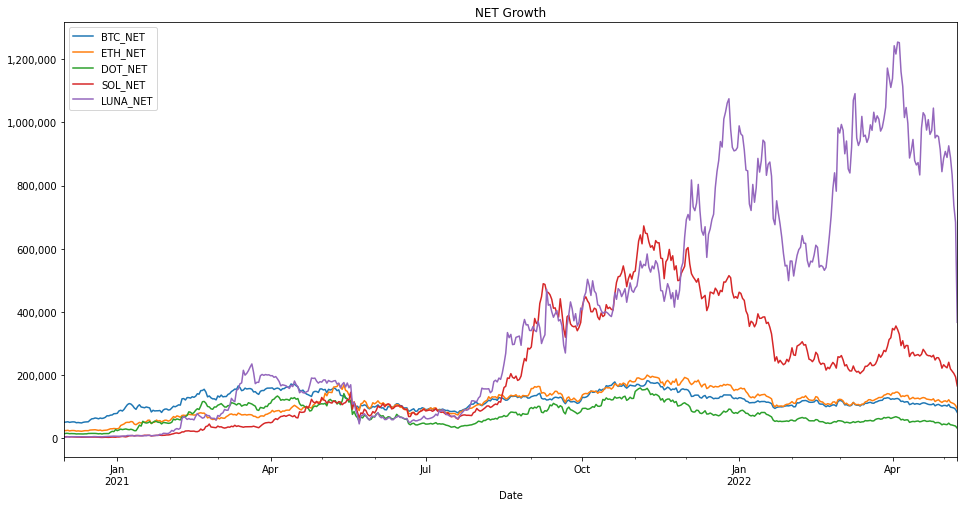

In [14]:
pl = hodl_portfolio_df.plot(y=['BTC_NET','ETH_NET','DOT_NET','SOL_NET','LUNA_NET'],figsize=(16,8),title='NET Growth')

# after plotting the data, format the labels
current_values = pl.get_yticks()
# using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


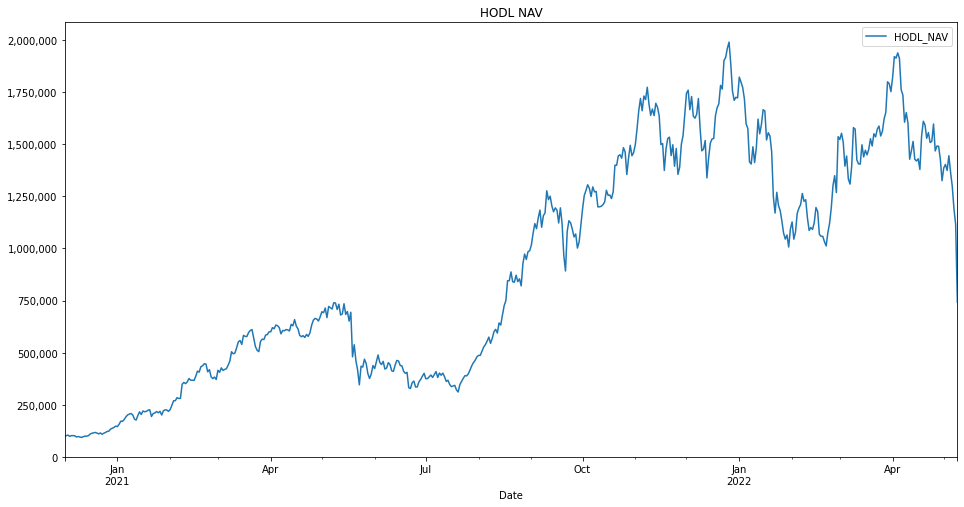

In [15]:
pl = hodl_portfolio_df.plot(y=['HODL_NAV'],figsize=(16,8),title='HODL NAV')
# after plotting the data, format the labels
current_values = pl.get_yticks()
# using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

# STAKING FUND

In [63]:
principal_usd = 100000
coins = ['ETH','SOL','AVAX','NEAR','FTM']
#coin_allocations = [0.70,0.10,0.10,0.05,0.05]
#coin_allocations = [0.20,0.20,0.20,0.20,0.20]
#coin_allocations = [0.10,0.70,0.10,0.05,0.05]
coin_allocations = [0.15,0.15,0.10,0.30,0.30]


eth_df = generate_df("ethereum_2020-12-1_2022-5-10.csv")
sol_df = generate_df("solana_2020-12-1_2022-5-10.csv")
avax_df = generate_df("avalanche_2020-12-1_2022-5-10.csv")
near_df = generate_df("near-protocol_2020-12-1_2022-5-10.csv")
ftm_df = generate_df("fantom_2020-12-1_2022-5-10.csv")
basket_portfolio_df = pd.concat([eth_df['Close'],sol_df['Close'],avax_df['Close'],near_df['Close'],ftm_df['Close']],axis=1)
basket_portfolio_df.columns = coins
basket_portfolio_df


,ETH,SOL,AVAX,NEAR,FTM
Date,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497
...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732


In [64]:
ETH_ALLOC = coin_allocations[0]
ETH_NET_ALLOC_USD = (ETH_ALLOC * principal_usd)
ETH_INIT_AMNT = round(ETH_NET_ALLOC_USD / float(basket_portfolio_df['ETH'].iloc[0]),2)
basket_portfolio_df['ETH_AMNT'] = ETH_INIT_AMNT
basket_portfolio_df['ETH_NET'] = round(ETH_INIT_AMNT * basket_portfolio_df['ETH'],2)

SOL_ALLOC = coin_allocations[1]
SOL_NET_ALLOC = (SOL_ALLOC * principal_usd)
SOL_INIT_AMNT = round(SOL_NET_ALLOC / float(basket_portfolio_df['SOL'].iloc[0]))
basket_portfolio_df['SOL_AMNT'] = SOL_INIT_AMNT
basket_portfolio_df['SOL_NET'] = round(SOL_INIT_AMNT * basket_portfolio_df['SOL'],2)

AVAX_ALLOC = coin_allocations[2]
AVAX_NET_ALLOC = (AVAX_ALLOC * principal_usd)
AVAX_INIT_AMNT = round(AVAX_NET_ALLOC / float(basket_portfolio_df['AVAX'].iloc[0]))
basket_portfolio_df['AVAX_AMNT'] = AVAX_INIT_AMNT
basket_portfolio_df['AVAX_NET'] = round(AVAX_INIT_AMNT * basket_portfolio_df['AVAX'],2)

# LUNA_ALLOC = coin_allocations[3]
# LUNA_NET_ALLOC = (LUNA_ALLOC * principal_usd)
# LUNA_INIT_AMNT = round(LUNA_NET_ALLOC / float(portfolio_df['LUNA'].iloc[0]))
# portfolio_df['LUNA_AMNT'] = LUNA_INIT_AMNT
# portfolio_df['LUNA_NET'] = round(LUNA_INIT_AMNT * portfolio_df['LUNA'],2)

NEAR_ALLOC = coin_allocations[3]
NEAR_NET_ALLOC = (NEAR_ALLOC * principal_usd)
NEAR_INIT_AMNT = round(NEAR_NET_ALLOC / float(basket_portfolio_df['NEAR'].iloc[0]))
basket_portfolio_df['NEAR_AMNT'] = NEAR_INIT_AMNT
basket_portfolio_df['NEAR_NET'] = round(NEAR_INIT_AMNT * basket_portfolio_df['NEAR'],2)

FTM_ALLOC = coin_allocations[4]
FTM_NET_ALLOC = (FTM_ALLOC * principal_usd)
FTM_INIT_AMNT = round(FTM_NET_ALLOC / float(basket_portfolio_df['FTM'].iloc[0]))
basket_portfolio_df['FTM_AMNT'] = FTM_INIT_AMNT
basket_portfolio_df['FTM_NET'] = round(FTM_INIT_AMNT * basket_portfolio_df['FTM'],2)
basket_portfolio_df['BASKET_NAV'] = basket_portfolio_df['ETH_NET'] + basket_portfolio_df['SOL_NET'] + basket_portfolio_df['AVAX_NET'] + basket_portfolio_df['NEAR_NET']+ basket_portfolio_df['FTM_NET']
basket_portfolio_df

,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET,BASKET_NAV
Date,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,25.43,14998.98,7585,14999.46,2796,9999.25,27893,29999.91,1460624,30000.00,99997.60
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,25.43,15216.22,7585,16022.21,2796,10473.33,27893,32812.00,1460624,33077.92,107601.68
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,25.43,15687.89,7585,15916.40,2796,10679.24,27893,32224.41,1460624,33431.28,107939.22
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,25.43,14545.41,7585,14082.83,2796,9945.28,27893,30872.74,1460624,30734.81,100181.07
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,25.43,15144.80,7585,14998.88,2796,10150.41,27893,30996.39,1460624,32859.83,104150.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458,25.43,70008.29,7585,641968.61,2796,165238.57,27893,313506.16,1460624,1085912.78,2276634.41
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,25.43,68656.55,7585,621665.08,2796,159583.66,27893,301294.61,1460624,1060507.61,2211707.51
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,25.43,67260.46,7585,600220.01,2796,154703.80,27893,292089.92,1460624,1001596.64,2115870.83


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


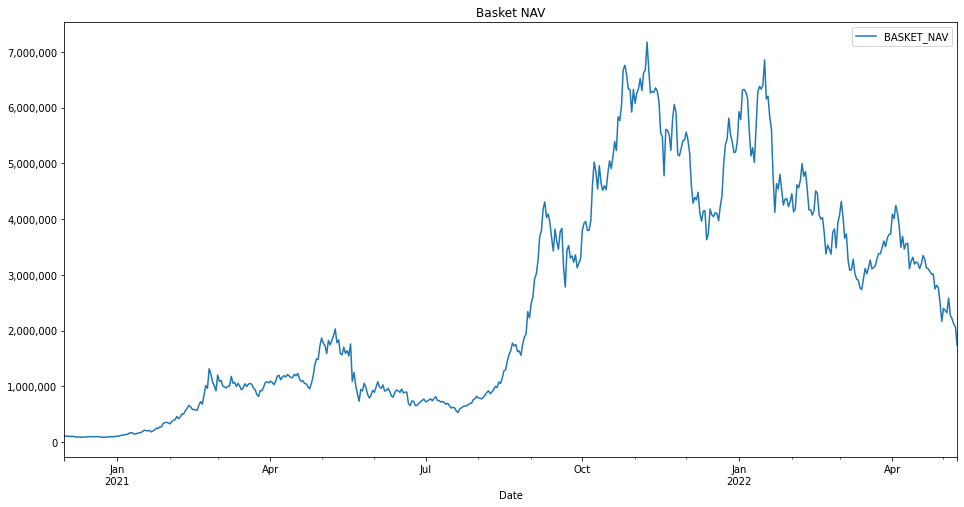

In [65]:
pl = basket_portfolio_df.plot(y=['BASKET_NAV'],figsize=(16,8),title='Basket NAV')
# after plotting the data, format the labels
current_values = pl.get_yticks()
# using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

In [66]:
principal_usd = 100000
coins = ['ETH','SOL','AVAX','LUNA','NEAR','FTM']
coin_allocations = [0.50,0.15,0.15,0.10,0.05,0.05]

eth_df = generate_df("ethereum_2020-12-1_2022-5-10.csv")
sol_df = generate_df("solana_2020-12-1_2022-5-10.csv")
avax_df = generate_df("avalanche_2020-12-1_2022-5-10.csv")
luna_df = generate_df("terra_2020-12-1_2022-5-10.csv")
ftm_df = generate_df("fantom_2020-12-1_2022-5-10.csv")
basket_luna_portfolio_df = pd.concat([eth_df['Close'],sol_df['Close'],avax_df['Close'],luna_df['Close'],near_df['Close'],ftm_df['Close']],axis=1)
basket_luna_portfolio_df.columns = coins
basket_luna_portfolio_df

,ETH,SOL,AVAX,LUNA,NEAR,FTM
Date,,,,,,
2020-12-01,589.814467,1.977516,3.576271,0.388320,1.075536,0.020539
2020-12-02,598.357253,2.112355,3.745825,0.406310,1.176352,0.022646
2020-12-03,616.904853,2.098405,3.819472,0.506414,1.155287,0.022888
2020-12-04,571.978333,1.856668,3.556966,0.451015,1.106827,0.021042
2020-12-05,595.548506,1.977440,3.630332,0.509040,1.111261,0.022497
...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,82.625100,11.239600,0.743458
2022-05-06,2699.825200,81.959800,57.075700,77.418900,10.801800,0.726065
2022-05-07,2644.925800,79.132500,55.330400,68.488700,10.471800,0.685732


In [67]:
ETH_ALLOC = coin_allocations[0]
ETH_NET_ALLOC_USD = (ETH_ALLOC * principal_usd)
ETH_INIT_AMNT = round(ETH_NET_ALLOC_USD / float(basket_luna_portfolio_df['ETH'].iloc[0]),2)
basket_luna_portfolio_df['ETH_AMNT'] = ETH_INIT_AMNT
basket_luna_portfolio_df['ETH_NET'] = round(ETH_INIT_AMNT * basket_luna_portfolio_df['ETH'],2)

SOL_ALLOC = coin_allocations[1]
SOL_NET_ALLOC = (SOL_ALLOC * principal_usd)
SOL_INIT_AMNT = round(SOL_NET_ALLOC / float(basket_luna_portfolio_df['SOL'].iloc[0]))
basket_luna_portfolio_df['SOL_AMNT'] = SOL_INIT_AMNT
basket_luna_portfolio_df['SOL_NET'] = round(SOL_INIT_AMNT * basket_luna_portfolio_df['SOL'],2)

AVAX_ALLOC = coin_allocations[2]
AVAX_NET_ALLOC = (AVAX_ALLOC * principal_usd)
AVAX_INIT_AMNT = round(AVAX_NET_ALLOC / float(basket_luna_portfolio_df['AVAX'].iloc[0]))
basket_luna_portfolio_df['AVAX_AMNT'] = AVAX_INIT_AMNT
basket_luna_portfolio_df['AVAX_NET'] = round(AVAX_INIT_AMNT * basket_luna_portfolio_df['AVAX'],2)

LUNA_ALLOC = coin_allocations[3]
LUNA_NET_ALLOC = (LUNA_ALLOC * principal_usd)
LUNA_INIT_AMNT = round(LUNA_NET_ALLOC / float(basket_luna_portfolio_df['LUNA'].iloc[0]))
basket_luna_portfolio_df['LUNA_AMNT'] = LUNA_INIT_AMNT
basket_luna_portfolio_df['LUNA_NET'] = round(LUNA_INIT_AMNT * basket_luna_portfolio_df['LUNA'],2)

NEAR_ALLOC = coin_allocations[4]
NEAR_NET_ALLOC = (NEAR_ALLOC * principal_usd)
NEAR_INIT_AMNT = round(NEAR_NET_ALLOC / float(basket_luna_portfolio_df['NEAR'].iloc[0]))
basket_luna_portfolio_df['NEAR_AMNT'] = NEAR_INIT_AMNT
basket_luna_portfolio_df['NEAR_NET'] = round(NEAR_INIT_AMNT * basket_luna_portfolio_df['NEAR'],2)

FTM_ALLOC = coin_allocations[5]
FTM_NET_ALLOC = (FTM_ALLOC * principal_usd)
FTM_INIT_AMNT = round(FTM_NET_ALLOC / float(basket_luna_portfolio_df['FTM'].iloc[0]))
basket_luna_portfolio_df['FTM_AMNT'] = FTM_INIT_AMNT
basket_luna_portfolio_df['FTM_NET'] = round(FTM_INIT_AMNT * basket_luna_portfolio_df['FTM'],2)
basket_luna_portfolio_df['LUNA_BASKET_NAV'] = basket_luna_portfolio_df['ETH_NET'] + basket_luna_portfolio_df['SOL_NET'] + basket_luna_portfolio_df['AVAX_NET'] + basket_luna_portfolio_df['LUNA_NET'] + basket_luna_portfolio_df['NEAR_NET']+ basket_luna_portfolio_df['FTM_NET']
basket_luna_portfolio_df

,ETH,SOL,AVAX,LUNA,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,LUNA_AMNT,LUNA_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET,LUNA_BASKET_NAV
Date,,,,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,0.388320,1.075536,0.020539,84.77,49998.57,7585,14999.46,4194,14998.88,25752,10000.01,4649,5000.16,243437,4999.99,99997.07
2020-12-02,598.357253,2.112355,3.745825,0.406310,1.176352,0.022646,84.77,50722.74,7585,16022.21,4194,15709.99,25752,10463.30,4649,5468.86,243437,5512.98,103900.08
2020-12-03,616.904853,2.098405,3.819472,0.506414,1.155287,0.022888,84.77,52295.02,7585,15916.40,4194,16018.87,25752,13041.17,4649,5370.93,243437,5571.87,108214.26
2020-12-04,571.978333,1.856668,3.556966,0.451015,1.106827,0.021042,84.77,48486.60,7585,14082.83,4194,14917.92,25752,11614.53,4649,5145.64,243437,5122.46,99369.98
2020-12-05,595.548506,1.977440,3.630332,0.509040,1.111261,0.022497,84.77,50484.65,7585,14998.88,4194,15225.61,25752,13108.81,4649,5166.25,243437,5476.63,104460.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,82.625100,11.239600,0.743458,84.77,233370.15,7585,641968.61,4194,247857.85,25752,2127761.58,4649,52252.90,243437,180985.21,3484196.30
2022-05-06,2699.825200,81.959800,57.075700,77.418900,10.801800,0.726065,84.77,228864.18,7585,621665.08,4194,239375.49,25752,1993691.51,4649,50217.57,243437,176751.03,3310564.86
2022-05-07,2644.925800,79.132500,55.330400,68.488700,10.471800,0.685732,84.77,224210.36,7585,600220.01,4194,232055.70,25752,1763721.00,4649,48683.40,243437,166932.55,3035823.02


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


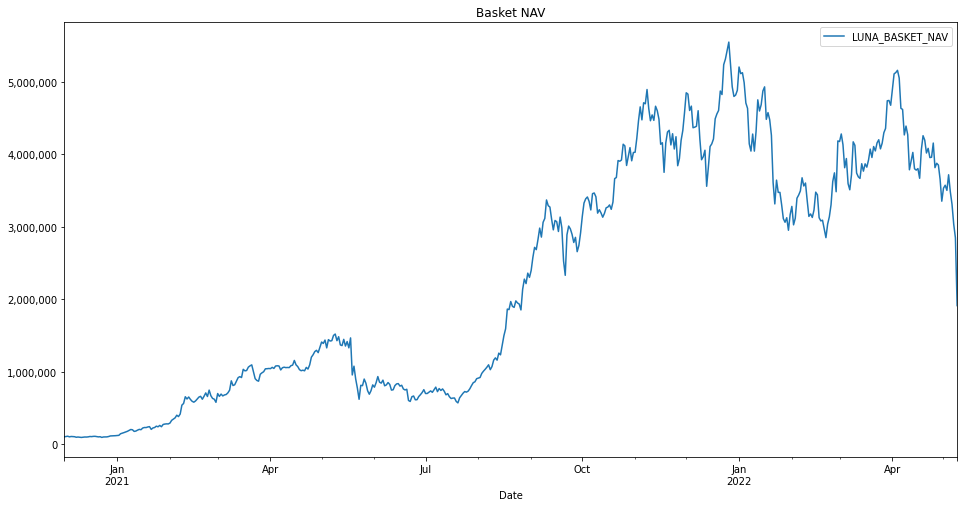

In [68]:
pl = basket_luna_portfolio_df.plot(y=['LUNA_BASKET_NAV'],figsize=(16,8),title='Basket NAV')
# after plotting the data, format the labels
current_values = pl.get_yticks()
# using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

In [69]:
basket_staking_portfolio_df = basket_portfolio_df.copy()
basket_staking_portfolio_df['Day_Count'] = 1
basket_staking_portfolio_df['Day_Count_Cum'] = basket_staking_portfolio_df['Day_Count'].cumsum()


ETH_ANNUAL_YIELD = 8.00 #4.37
ETH_ANNUAL_YIELD_PERCENTAGE = ETH_ANNUAL_YIELD / 100
ETH_DAILY_YIELD_PERCENTAGE = (1 + ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_ETH_YIELD_AMNT = ETH_INIT_AMNT * ETH_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['ETH_Daily_Rate'] = ETH_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['ETH_AMNT_YIELD'] = basket_staking_portfolio_df['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (basket_staking_portfolio_df['Day_Count_Cum'])
basket_staking_portfolio_df['ETH_NET_YIELD'] = round(basket_staking_portfolio_df['ETH_AMNT_YIELD'] * basket_staking_portfolio_df['ETH'],2)

SOL_ANNUAL_YIELD = 5.75
SOL_ANNUAL_YIELD_PERCENTAGE = SOL_ANNUAL_YIELD / 100
SOL_DAILY_YIELD_PERCENTAGE = (1 + SOL_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_SOL_YIELD_AMNT = SOL_INIT_AMNT * SOL_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['SOL_Daily_Rate'] = SOL_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['SOL_AMNT_YIELD'] = basket_staking_portfolio_df['SOL_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (basket_staking_portfolio_df['Day_Count_Cum'])
basket_staking_portfolio_df['SOL_NET_YIELD'] = round(basket_staking_portfolio_df['SOL_AMNT_YIELD'] * basket_staking_portfolio_df['SOL'],2)

AVAX_ANNUAL_YIELD = 9.39
AVAX_ANNUAL_YIELD_PERCENTAGE = AVAX_ANNUAL_YIELD / 100
AVAX_DAILY_YIELD_PERCENTAGE = (1 + AVAX_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_AVAX_YIELD_AMNT = AVAX_INIT_AMNT * AVAX_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['AVAX_Daily_Rate'] = AVAX_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['AVAX_AMNT_YIELD'] = basket_staking_portfolio_df['AVAX_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (basket_staking_portfolio_df['Day_Count_Cum'])
basket_staking_portfolio_df['AVAX_NET_YIELD'] = round(basket_staking_portfolio_df['AVAX_AMNT_YIELD'] * basket_staking_portfolio_df['AVAX'],2)


NEAR_ANNUAL_YIELD = 10
NEAR_ANNUAL_YIELD_PERCENTAGE = NEAR_ANNUAL_YIELD / 100
NEAR_DAILY_YIELD_PERCENTAGE = (1 + NEAR_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_NEAR_YIELD_AMNT = NEAR_INIT_AMNT * NEAR_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['NEAR_Daily_Rate'] = NEAR_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['NEAR_AMNT_YIELD'] = basket_staking_portfolio_df['NEAR_AMNT'] * (1 + NEAR_DAILY_YIELD_PERCENTAGE) ** (basket_staking_portfolio_df['Day_Count_Cum'])
basket_staking_portfolio_df['NEAR_NET_YIELD'] = round(basket_staking_portfolio_df['NEAR_AMNT_YIELD'] * basket_staking_portfolio_df['NEAR'],2)


FTM_ANNUAL_YIELD = 14.19
FTM_ANNUAL_YIELD_PERCENTAGE = FTM_ANNUAL_YIELD / 100
FTM_DAILY_YIELD_PERCENTAGE = (1 + FTM_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_FTM_YIELD_AMNT = FTM_INIT_AMNT * FTM_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['FTM_Daily_Rate'] = FTM_DAILY_YIELD_PERCENTAGE
basket_staking_portfolio_df['FTM_AMNT_YIELD'] = basket_staking_portfolio_df['FTM_AMNT'] * (1 + FTM_DAILY_YIELD_PERCENTAGE) ** (basket_staking_portfolio_df['Day_Count_Cum'])
basket_staking_portfolio_df['FTM_NET_YIELD'] = round(basket_staking_portfolio_df['FTM_AMNT_YIELD'] * basket_staking_portfolio_df['FTM'],2)


basket_staking_portfolio_df['basket_staking_nav'] = basket_staking_portfolio_df['ETH_NET_YIELD'] + basket_staking_portfolio_df['SOL_NET_YIELD'] + basket_staking_portfolio_df['AVAX_NET_YIELD']  + basket_staking_portfolio_df['NEAR_NET_YIELD'] + basket_staking_portfolio_df['FTM_NET_YIELD']
basket_staking_portfolio_df

,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,...,AVAX_Daily_Rate,AVAX_AMNT_YIELD,AVAX_NET_YIELD,NEAR_Daily_Rate,NEAR_AMNT_YIELD,NEAR_NET_YIELD,FTM_Daily_Rate,FTM_AMNT_YIELD,FTM_NET_YIELD,basket_staking_nav
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,1.075536,0.020539,25.43,14998.98,7585,14999.46,2796,...,0.000246,2796.428301,10000.79,0.000261,27900.284477,30007.75,0.000364,1.461155e+06,30010.91,100023.35
2020-12-02,598.357253,2.112355,3.745825,1.176352,0.022646,25.43,15216.22,7585,16022.21,2796,...,0.000246,2796.856667,10476.54,0.000261,27907.570856,32829.14,0.000364,1.461686e+06,33101.98,107657.42
2020-12-03,616.904853,2.098405,3.819472,1.155287,0.022888,25.43,15687.89,7585,15916.40,2796,...,0.000246,2797.285099,10684.15,0.000261,27914.859138,32249.66,0.000364,1.462218e+06,33467.76,108023.11
2020-12-04,571.978333,1.856668,3.556966,1.106827,0.021042,25.43,14545.41,7585,14082.83,2796,...,0.000246,2797.713596,9951.37,0.000261,27922.149323,30905.00,0.000364,1.462750e+06,30779.54,100285.05
2020-12-05,595.548506,1.977440,3.630332,1.111261,0.022497,25.43,15144.80,7585,14998.88,2796,...,0.000246,2798.142159,10158.19,0.000261,27929.441412,31036.89,0.000364,1.463281e+06,32919.62,104285.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458,25.43,70008.29,7585,641968.61,2796,...,0.000246,3028.272197,178965.44,0.000261,31957.958777,359194.67,0.000364,1.765211e+06,1312360.34,2623956.65
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,25.43,68656.55,7585,621665.08,2796,...,0.000246,3028.736078,172867.23,0.000261,31966.304850,345293.63,0.000364,1.765853e+06,1282123.41,2550340.88
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,25.43,67260.46,7585,600220.01,2796,...,0.000246,3029.200030,167606.85,0.000261,31974.653102,334832.17,0.000364,1.766495e+06,1211342.02,2439164.41


In [70]:
basket_staking_luna_portfolio_df = basket_luna_portfolio_df.copy()
basket_staking_luna_portfolio_df['Day_Count'] = 1
basket_staking_luna_portfolio_df['Day_Count_Cum'] = basket_staking_luna_portfolio_df['Day_Count'].cumsum()

ETH_ANNUAL_YIELD = 8.00 #4.37
ETH_ANNUAL_YIELD_PERCENTAGE = ETH_ANNUAL_YIELD / 100
ETH_DAILY_YIELD_PERCENTAGE = (1 + ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_ETH_YIELD_AMNT = ETH_INIT_AMNT * ETH_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['ETH_Daily_Rate'] = ETH_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['ETH_AMNT_YIELD'] = basket_staking_luna_portfolio_df['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (basket_staking_luna_portfolio_df['Day_Count_Cum'])
basket_staking_luna_portfolio_df['ETH_NET_YIELD'] = round(basket_staking_luna_portfolio_df['ETH_AMNT_YIELD'] * basket_staking_luna_portfolio_df['ETH'],2)

SOL_ANNUAL_YIELD = 5.75
SOL_ANNUAL_YIELD_PERCENTAGE = SOL_ANNUAL_YIELD / 100
SOL_DAILY_YIELD_PERCENTAGE = (1 + SOL_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_SOL_YIELD_AMNT = SOL_INIT_AMNT * SOL_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['SOL_Daily_Rate'] = SOL_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['SOL_AMNT_YIELD'] = basket_staking_luna_portfolio_df['SOL_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (basket_staking_luna_portfolio_df['Day_Count_Cum'])
basket_staking_luna_portfolio_df['SOL_NET_YIELD'] = round(basket_staking_luna_portfolio_df['SOL_AMNT_YIELD'] * basket_staking_luna_portfolio_df['SOL'],2)

AVAX_ANNUAL_YIELD = 9.39
AVAX_ANNUAL_YIELD_PERCENTAGE = AVAX_ANNUAL_YIELD / 100
AVAX_DAILY_YIELD_PERCENTAGE = (1 + AVAX_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_AVAX_YIELD_AMNT = AVAX_INIT_AMNT * AVAX_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['AVAX_Daily_Rate'] = AVAX_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['AVAX_AMNT_YIELD'] = basket_staking_portfolio_df['AVAX_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (basket_staking_luna_portfolio_df['Day_Count_Cum'])
basket_staking_luna_portfolio_df['AVAX_NET_YIELD'] = round(basket_staking_luna_portfolio_df['AVAX_AMNT_YIELD'] * basket_staking_luna_portfolio_df['AVAX'],2)

LUNA_ANNUAL_YIELD = 10.00
LUNA_ANNUAL_YIELD_PERCENTAGE = LUNA_ANNUAL_YIELD / 100
LUNA_DAILY_YIELD_PERCENTAGE = (1 + LUNA_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_LUNA_YIELD_AMNT = LUNA_INIT_AMNT * LUNA_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['Daily_Rate'] = LUNA_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['LUNA_AMNT_YIELD'] = basket_staking_luna_portfolio_df['LUNA_AMNT'] * (1 + LUNA_DAILY_YIELD_PERCENTAGE) ** (basket_staking_luna_portfolio_df['Day_Count_Cum'])
basket_staking_luna_portfolio_df['LUNA_NET_YIELD'] = round(basket_staking_luna_portfolio_df['LUNA_AMNT_YIELD'] * basket_staking_luna_portfolio_df['LUNA'],2)

NEAR_ANNUAL_YIELD = 10
NEAR_ANNUAL_YIELD_PERCENTAGE = NEAR_ANNUAL_YIELD / 100
NEAR_DAILY_YIELD_PERCENTAGE = (1 + NEAR_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_NEAR_YIELD_AMNT = NEAR_INIT_AMNT * NEAR_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['NEAR_Daily_Rate'] = NEAR_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['NEAR_AMNT_YIELD'] = basket_staking_luna_portfolio_df['NEAR_AMNT'] * (1 + NEAR_DAILY_YIELD_PERCENTAGE) ** (basket_staking_luna_portfolio_df['Day_Count_Cum'])
basket_staking_luna_portfolio_df['NEAR_NET_YIELD'] = round(basket_staking_luna_portfolio_df['NEAR_AMNT_YIELD'] * basket_staking_luna_portfolio_df['NEAR'],2)

FTM_ANNUAL_YIELD = 14.19
FTM_ANNUAL_YIELD_PERCENTAGE = FTM_ANNUAL_YIELD / 100
FTM_DAILY_YIELD_PERCENTAGE = (1 + FTM_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_FTM_YIELD_AMNT = FTM_INIT_AMNT * FTM_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['FTM_Daily_Rate'] = FTM_DAILY_YIELD_PERCENTAGE
basket_staking_luna_portfolio_df['FTM_AMNT_YIELD'] = basket_staking_luna_portfolio_df['FTM_AMNT'] * (1 + FTM_DAILY_YIELD_PERCENTAGE) ** (basket_staking_luna_portfolio_df['Day_Count_Cum'])
basket_staking_luna_portfolio_df['FTM_NET_YIELD'] = round(basket_staking_luna_portfolio_df['FTM_AMNT_YIELD'] * basket_staking_luna_portfolio_df['FTM'],2)
basket_staking_luna_portfolio_df['basket_staking_luna_nav'] = basket_staking_luna_portfolio_df['ETH_NET_YIELD'] + basket_staking_luna_portfolio_df['SOL_NET_YIELD'] + basket_staking_luna_portfolio_df['AVAX_NET_YIELD']  + basket_staking_luna_portfolio_df['NEAR_NET_YIELD'] + basket_staking_luna_portfolio_df['FTM_NET_YIELD'] + basket_staking_luna_portfolio_df['LUNA_NET_YIELD']

basket_staking_luna_portfolio_df

,ETH,SOL,AVAX,LUNA,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,...,Daily_Rate,LUNA_AMNT_YIELD,LUNA_NET_YIELD,NEAR_Daily_Rate,NEAR_AMNT_YIELD,NEAR_NET_YIELD,FTM_Daily_Rate,FTM_AMNT_YIELD,FTM_NET_YIELD,basket_staking_luna_nav
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,589.814467,1.977516,3.576271,0.388320,1.075536,0.020539,84.77,49998.57,7585,14999.46,...,0.000261,25758.725338,10002.62,0.000261,4650.214123,5001.47,0.000364,243525.516137,5001.81,95017.57
2020-12-02,598.357253,2.112355,3.745825,0.406310,1.176352,0.022646,84.77,50722.74,7585,16022.21,...,0.000261,25765.452432,10468.76,0.000261,4651.428563,5471.72,0.000364,243614.064460,5516.99,98705.27
2020-12-03,616.904853,2.098405,3.819472,0.506414,1.155287,0.022888,84.77,52295.02,7585,15916.40,...,0.000261,25772.181282,13051.39,0.000261,4652.643320,5375.14,0.000364,243702.644980,5577.95,102940.46
2020-12-04,571.978333,1.856668,3.556966,0.451015,1.106827,0.021042,84.77,48486.60,7585,14082.83,...,0.000261,25778.911891,11626.67,0.000261,4653.858395,5151.02,0.000364,243791.257708,5129.92,94477.95
2020-12-05,595.548506,1.977440,3.630332,0.509040,1.111261,0.022497,84.77,50484.65,7585,14998.88,...,0.000261,25785.644256,13125.93,0.000261,4655.073786,5173.00,0.000364,243879.902657,5486.60,99491.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,82.625100,11.239600,0.743458,84.77,233370.15,7585,641968.61,...,0.000261,29504.942259,2437848.80,0.000261,5326.517419,59867.93,0.000364,294201.403895,218726.42,3851175.42
2022-05-06,2699.825200,81.959800,57.075700,77.418900,10.801800,0.726065,84.77,228864.18,7585,621665.08,...,0.000261,29512.647707,2284836.72,0.000261,5327.908481,57551.00,0.000364,294308.378479,213686.94,3657846.35
2022-05-07,2644.925800,79.132500,55.330400,68.488700,10.471800,0.685732,84.77,224210.36,7585,600220.01,...,0.000261,29520.355168,2021810.75,0.000261,5329.299906,55807.36,0.000364,294415.391960,201890.06,3347746.43


In [71]:
foo_portfolio_df = pd.concat([btc_df['Close'],eth_df['Close']],axis=1)
foo_portfolio_df.columns = ['BTC','ETH']

BTC_ALLOC = 0.5
BTC_NET_ALLOC_USD = (BTC_ALLOC * principal_usd)
BTC_INIT_AMNT = round(BTC_NET_ALLOC_USD / float(foo_portfolio_df['BTC'].iloc[0]),2)
foo_portfolio_df['BTC_AMNT'] = BTC_INIT_AMNT
foo_portfolio_df['BTC_NET'] = round(BTC_INIT_AMNT * foo_portfolio_df['BTC'],2)


ETH_ALLOC = 0.5
ETH_NET_ALLOC_USD = (ETH_ALLOC * principal_usd)
ETH_INIT_AMNT = round(ETH_NET_ALLOC_USD / float(foo_portfolio_df['ETH'].iloc[0]),2)
foo_portfolio_df['ETH_AMNT'] = ETH_INIT_AMNT
foo_portfolio_df['ETH_NET'] = round(ETH_INIT_AMNT * foo_portfolio_df['ETH'],2)

foo_portfolio_df

,BTC,ETH,BTC_AMNT,BTC_NET,ETH_AMNT,ETH_NET
Date,,,,,,
2020-12-01,18855.043740,589.814467,2.65,49965.87,84.77,49998.57
2020-12-02,19201.276131,598.357253,2.65,50883.38,84.77,50722.74
2020-12-03,19427.954960,616.904853,2.65,51484.08,84.77,52295.02
2020-12-04,18737.192660,571.978333,2.65,49653.56,84.77,48486.60
2020-12-05,19127.656824,595.548506,2.65,50688.29,84.77,50484.65
...,...,...,...,...,...,...
2022-05-05,36568.759600,2752.980400,2.65,96907.21,84.77,233370.15
2022-05-06,36033.063400,2699.825200,2.65,95487.62,84.77,228864.18
2022-05-07,35552.564000,2644.925800,2.65,94214.29,84.77,224210.36


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


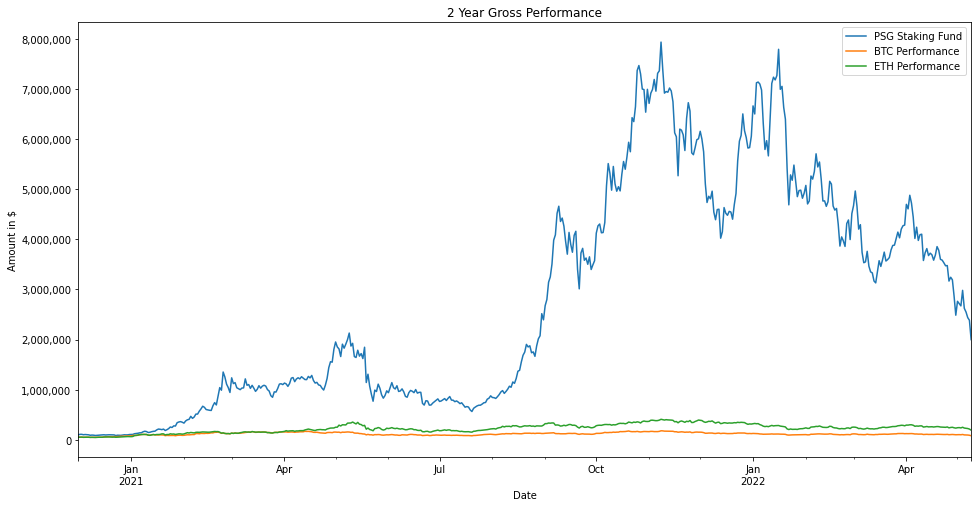

In [72]:
compare_df = pd.DataFrame(columns =['Date','21Shares HODL ETP','Basket No Yield','PSG Staking Fund','BTC Performance','ETH Performance'])





compare_df.set_index('Date',inplace=True)
compare_df['21Shares HODL ETP'] = hodl_portfolio_df['HODL_NAV']
compare_df['Basket No Yield'] = basket_portfolio_df['BASKET_NAV']
compare_df['PSG Staking Fund'] = basket_staking_portfolio_df['basket_staking_nav']
#hodl_portfolio_df['BTC_NET'] = round(BTC_INIT_AMNT * hodl_portfolio_df['BTC'],2)
compare_df['BTC Performance'] = foo_portfolio_df['BTC_NET']
compare_df['ETH Performance'] = foo_portfolio_df['ETH_NET']
pl = compare_df.plot(y=['PSG Staking Fund','BTC Performance','ETH Performance'],figsize=(16,8),title='2 Year Gross Performance')
pl.set_ylabel('Amount in $')
#compare_df
# pd.concat([hodl_portfolio_df['HODL_NAV'],basket_luna_portfolio_df['LUNA_BASKET_NAV'],basket_portfolio_df['BASKET_NAV']])
# compare_df.columns =

# .plot(y=['BASKET_NAV','LUNA_BASKET_NAV','HODL_NAV'],figsize=(16,8),title='NAV Performance Comparison')
# # after plotting the data, format the labels
current_values = pl.get_yticks()
# # using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


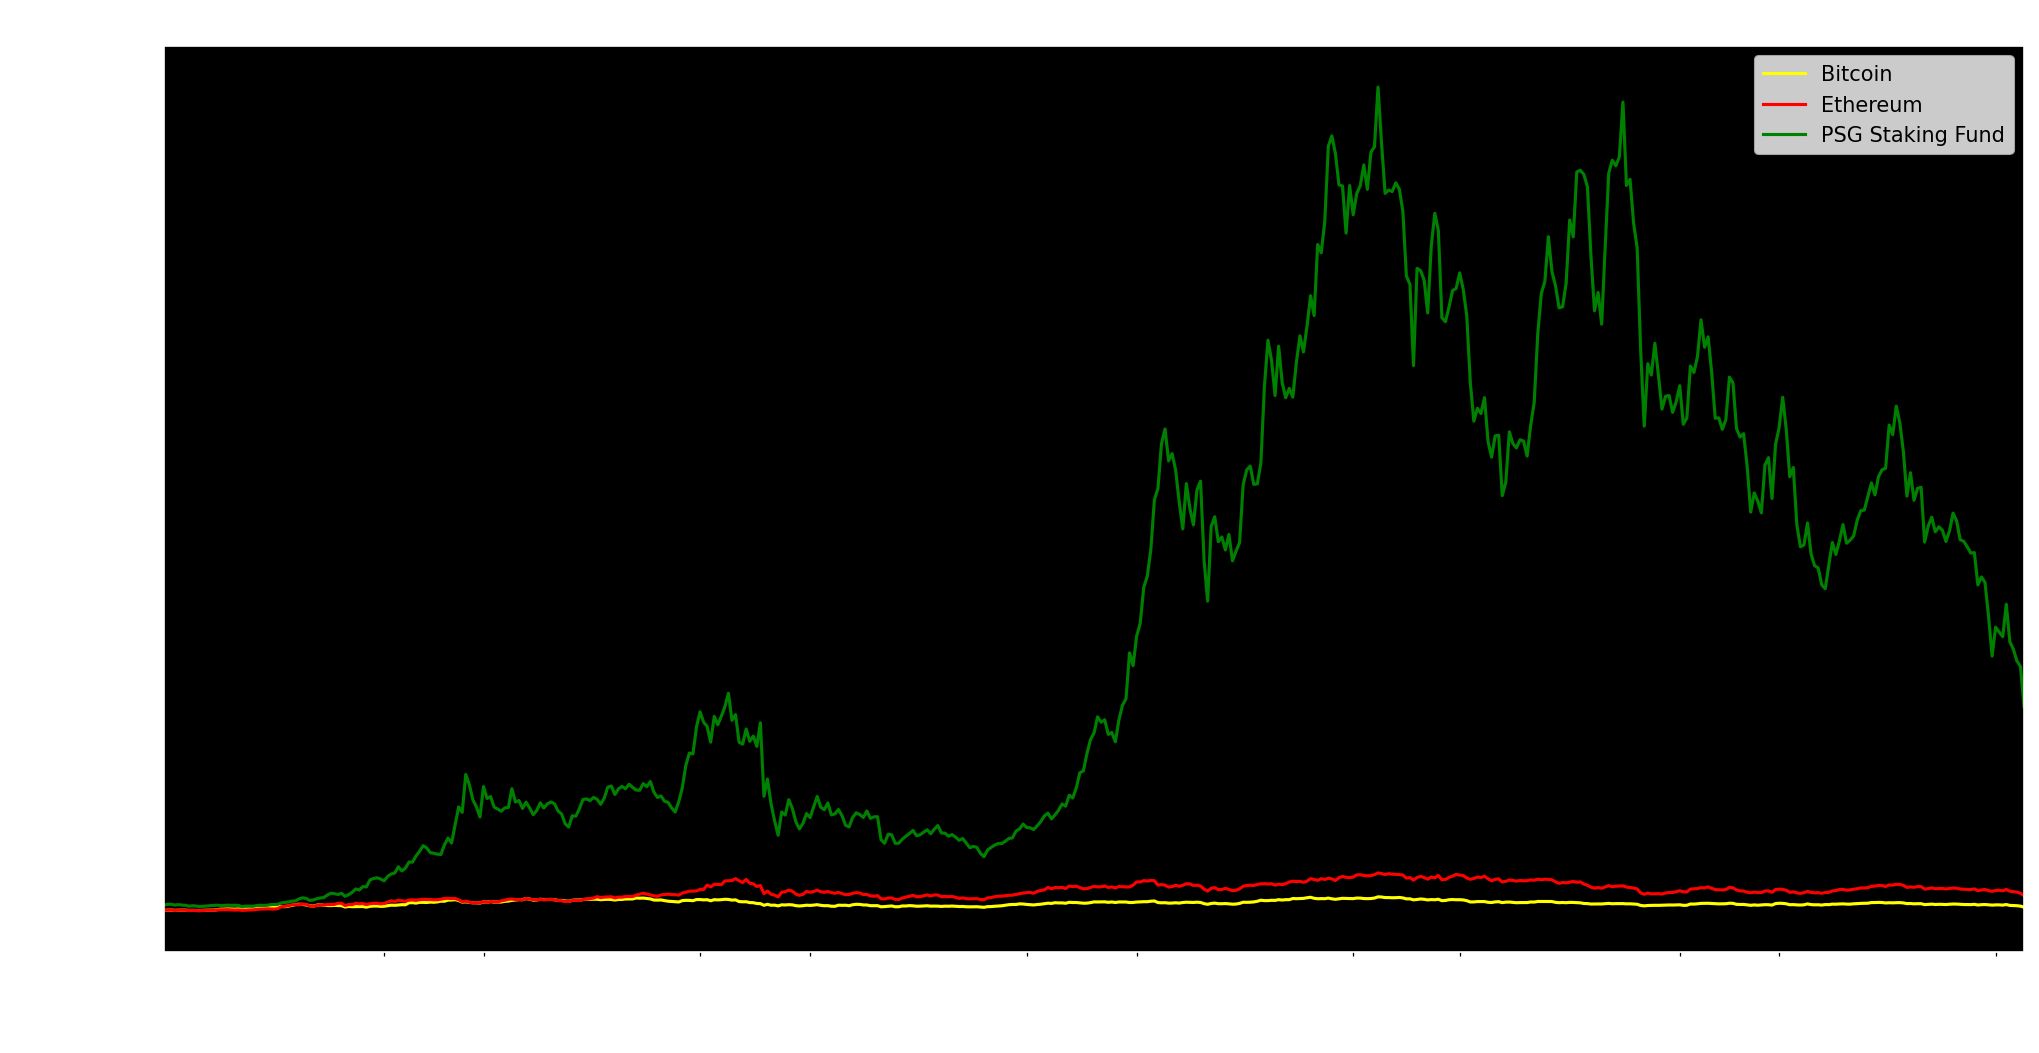

In [73]:
plt.figure(figsize=(16, 8), dpi=150)
ax = plt.axes()

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor("black");
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
compare_df['BTC Performance'].plot(label='Bitcoin', color='yellow')
compare_df['ETH Performance'].plot(label='Ethereum', color='red')
compare_df['PSG Staking Fund'].plot(label='PSG Staking Fund', color='green')
  
# adding title to the plot
plt.title('2 Year Comparison Over Market Performance',color="white")
  
# adding Label to the x-axis
plt.xlabel('Time Over 2 Years',color='white')
plt.ylabel('Amount in $',color='white')

current_values = ax.get_yticks()
# # using format string '{:.0f}' here but you can choose others
ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);  
# adding legend to the curve
plt.legend()

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


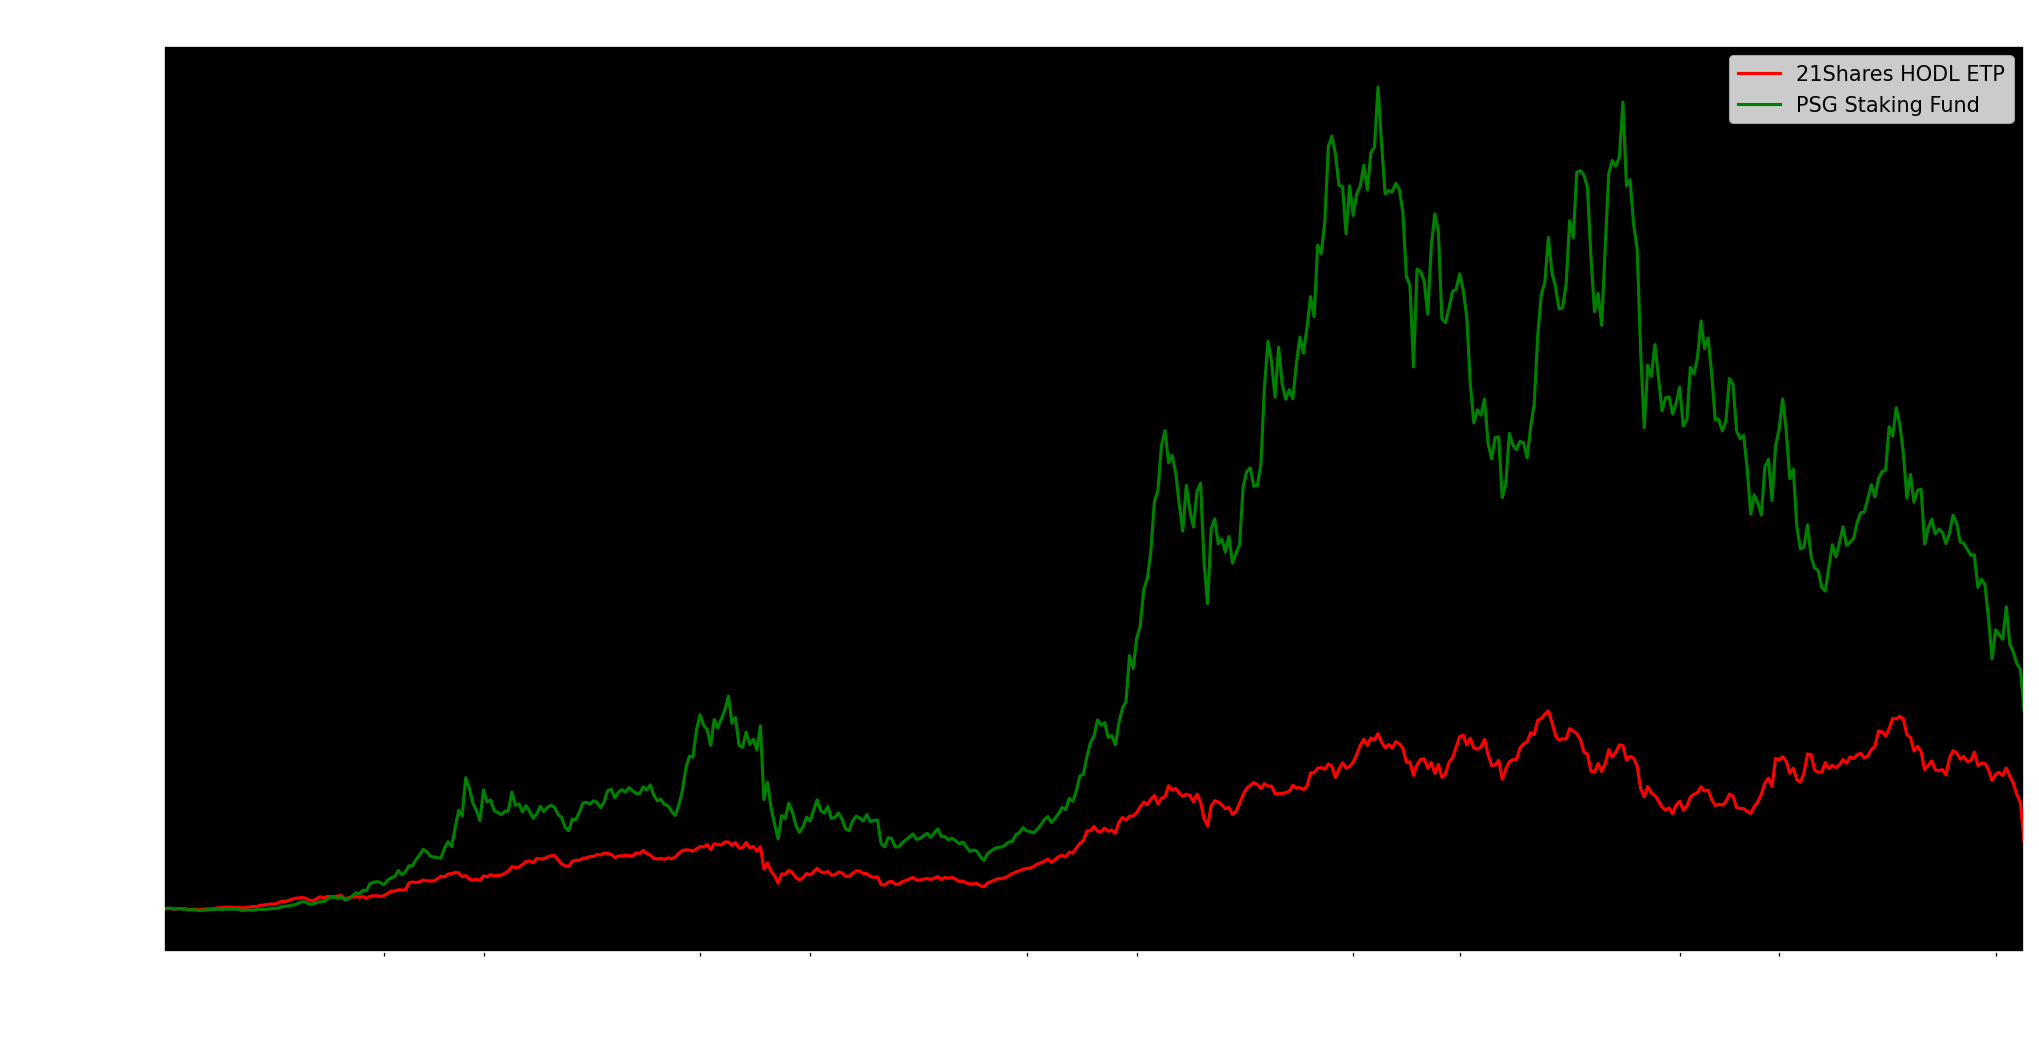

In [74]:
plt.figure(figsize=(16, 8), dpi=150)
ax = plt.axes()

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor("black");
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
compare_df['21Shares HODL ETP'].plot(label='21Shares HODL ETP', color='red')
compare_df['PSG Staking Fund'].plot(label='PSG Staking Fund', color='green')
  
# adding title to the plot
plt.title('2 Year Comparison Over 21 Shares ETP Performance',color="white")
  
# adding Label to the x-axis
plt.xlabel('Time Over 2 Years',color='white')
plt.ylabel('Amount in $',color='white')

current_values = ax.get_yticks()
# # using format string '{:.0f}' here but you can choose others
ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);
# adding legend to the curve
plt.legend()

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


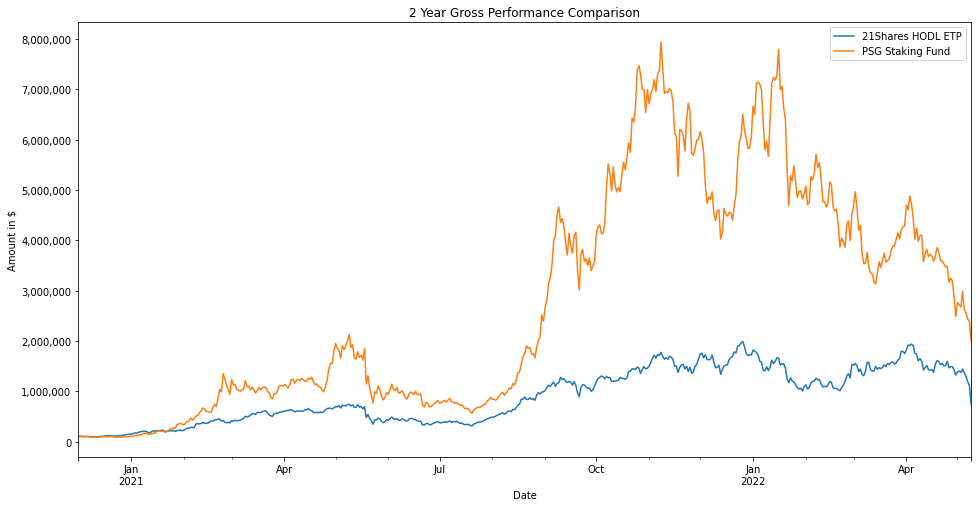

In [75]:
compare_df = pd.DataFrame(columns =['Date','21Shares HODL ETP','Basket No Yield','PSG Staking Fund'])

compare_df.set_index('Date',inplace=True)
compare_df['21Shares HODL ETP'] = hodl_portfolio_df['HODL_NAV']
compare_df['Basket No Yield'] = basket_portfolio_df['BASKET_NAV']
compare_df['PSG Staking Fund'] = basket_staking_portfolio_df['basket_staking_nav']
pl = compare_df.plot(y=['21Shares HODL ETP','PSG Staking Fund'],figsize=(16,8),title='2 Year Gross Performance Comparison')
pl.set_ylabel('Amount in $')
#compare_df
# pd.concat([hodl_portfolio_df['HODL_NAV'],basket_luna_portfolio_df['LUNA_BASKET_NAV'],basket_portfolio_df['BASKET_NAV']])
# compare_df.columns =

# .plot(y=['BASKET_NAV','LUNA_BASKET_NAV','HODL_NAV'],figsize=(16,8),title='NAV Performance Comparison')
# # after plotting the data, format the labels
current_values = pl.get_yticks()
# # using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


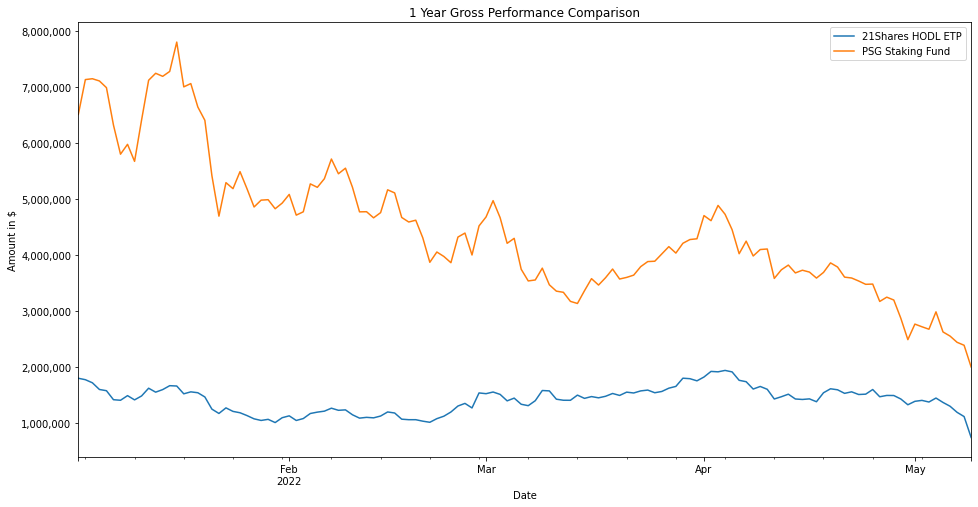

In [76]:
compare_df = pd.DataFrame(columns =['Date','21Shares HODL ETP','Basket No Yield','PSG Staking Fund'])

compare_df.set_index('Date',inplace=True)
compare_df['21Shares HODL ETP'] = hodl_portfolio_df['HODL_NAV']
compare_df['Basket No Yield'] = basket_portfolio_df['BASKET_NAV']
compare_df['PSG Staking Fund'] = basket_staking_portfolio_df['basket_staking_nav']
one_year_compare_df = compare_df[compare_df.index > datetime(2022,1,1)]

pl = one_year_compare_df.plot(y=['21Shares HODL ETP','PSG Staking Fund'],figsize=(16,8),title='1 Year Gross Performance Comparison')
pl.set_ylabel('Amount in $')
#compare_df
# pd.concat([hodl_portfolio_df['HODL_NAV'],basket_luna_portfolio_df['LUNA_BASKET_NAV'],basket_portfolio_df['BASKET_NAV']])
# compare_df.columns =

# .plot(y=['BASKET_NAV','LUNA_BASKET_NAV','HODL_NAV'],figsize=(16,8),title='NAV Performance Comparison')
# # after plotting the data, format the labels
current_values = pl.get_yticks()
# # using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


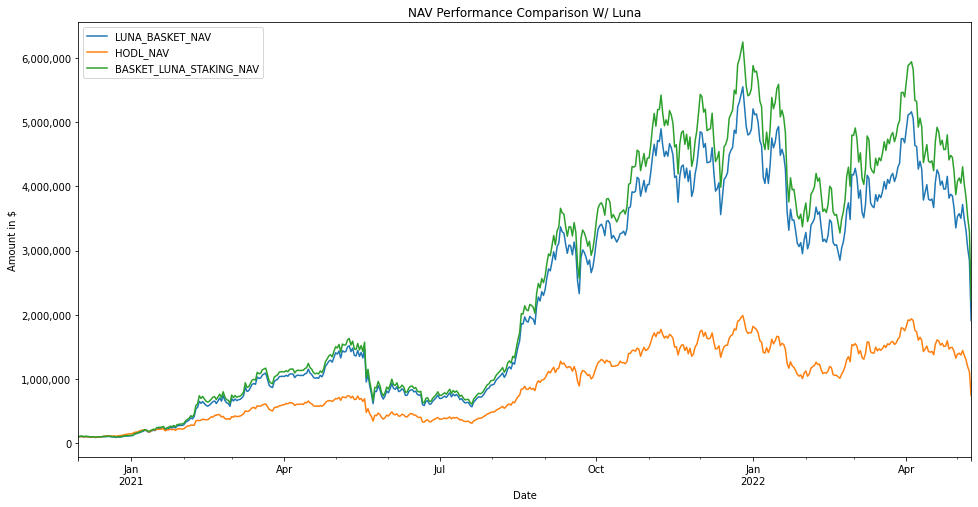

In [48]:
compare_df = pd.DataFrame(columns =['Date','HODL_NAV','LUNA_BASKET_NAV','BASKET_LUNA_STAKING_NAV'])

compare_df.set_index('Date',inplace=True)
compare_df['HODL_NAV'] = hodl_portfolio_df['HODL_NAV']
compare_df['LUNA_BASKET_NAV'] = basket_luna_portfolio_df['LUNA_BASKET_NAV']
compare_df['BASKET_LUNA_STAKING_NAV'] = basket_staking_luna_portfolio_df['basket_staking_luna_nav']
pl = compare_df.plot(y=['LUNA_BASKET_NAV','HODL_NAV','BASKET_LUNA_STAKING_NAV'],figsize=(16,8),title='NAV Performance Comparison W/ Luna')
pl.set_ylabel('Amount in $')
current_values = pl.get_yticks()
# # using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

In [33]:
"""
https://21shares.com/product/hodlx/
Underlying Assets
Cryptocurrency	Weighting	Quantity per ETP	Reference Price
Bitcoin	56.12%	0.00025461 ($7.91)	$31065.32
Ethereum	27.42%	0.00163931 ($3.86)	$2357.00
Binance Coin	4.93%	0.00218713 ($0.70)	$317.86
XRP	2.67%	0.73117938 ($0.38)	$0.51
Cardano	2.32%	0.49349887 ($0.33)	$0.66
Solana	2.25%	0.00457644 ($0.32)	$69.24
Avalanche	1.32%	0.00400144 ($0.19)	$46.65
Polkadot	1.16%	0.01430569 ($0.16)	$11.46
Terra	1.02%	0.00488605 ($0.14)	$29.31
Polygon	0.78%	0.12040035 ($0.11)	$0.91
""";

In [34]:
principal_usd = 100000
coins = ['ETH','SOL','AVAX','NEAR','FTM']
coin_allocations = [0.50,0.15,0.15,0.10,0.10]

eth_df = generate_df("ethereum_2020-12-1_2022-5-10.csv")
sol_df = generate_df("solana_2020-12-1_2022-5-10.csv")
avax_df = generate_df("avalanche_2020-12-1_2022-5-10.csv")
near_df = generate_df("near-protocol_2020-12-1_2022-5-10.csv")
ftm_df = generate_df("fantom_2020-12-1_2022-5-10.csv")
one_year_basket_portfolio_df = pd.concat([eth_df['Close'],sol_df['Close'],avax_df['Close'],near_df['Close'],ftm_df['Close']],axis=1)
one_year_basket_portfolio_df.columns = coins

one_year_basket_portfolio_df = one_year_basket_portfolio_df[one_year_basket_portfolio_df.index > datetime(2021,5,10)]

ETH_ALLOC = coin_allocations[0]
ETH_NET_ALLOC_USD = (ETH_ALLOC * principal_usd)
ETH_INIT_AMNT = round(ETH_NET_ALLOC_USD / float(one_year_basket_portfolio_df['ETH'].iloc[0]),2)
one_year_basket_portfolio_df['ETH_AMNT'] = ETH_INIT_AMNT
one_year_basket_portfolio_df['ETH_NET'] = round(ETH_INIT_AMNT * one_year_basket_portfolio_df['ETH'],2)

SOL_ALLOC = coin_allocations[1]
SOL_NET_ALLOC = (SOL_ALLOC * principal_usd)
SOL_INIT_AMNT = round(SOL_NET_ALLOC / float(one_year_basket_portfolio_df['SOL'].iloc[0]))
one_year_basket_portfolio_df['SOL_AMNT'] = SOL_INIT_AMNT
one_year_basket_portfolio_df['SOL_NET'] = round(SOL_INIT_AMNT * one_year_basket_portfolio_df['SOL'],2)

AVAX_ALLOC = coin_allocations[2]
AVAX_NET_ALLOC = (AVAX_ALLOC * principal_usd)
AVAX_INIT_AMNT = round(AVAX_NET_ALLOC / float(one_year_basket_portfolio_df['AVAX'].iloc[0]))
one_year_basket_portfolio_df['AVAX_AMNT'] = AVAX_INIT_AMNT
one_year_basket_portfolio_df['AVAX_NET'] = round(AVAX_INIT_AMNT * one_year_basket_portfolio_df['AVAX'],2)

NEAR_ALLOC = coin_allocations[3]
NEAR_NET_ALLOC = (NEAR_ALLOC * principal_usd)
NEAR_INIT_AMNT = round(NEAR_NET_ALLOC / float(one_year_basket_portfolio_df['NEAR'].iloc[0]))
one_year_basket_portfolio_df['NEAR_AMNT'] = NEAR_INIT_AMNT
one_year_basket_portfolio_df['NEAR_NET'] = round(NEAR_INIT_AMNT * one_year_basket_portfolio_df['NEAR'],2)

FTM_ALLOC = coin_allocations[4]
FTM_NET_ALLOC = (FTM_ALLOC * principal_usd)
FTM_INIT_AMNT = round(FTM_NET_ALLOC / float(one_year_basket_portfolio_df['FTM'].iloc[0]))
one_year_basket_portfolio_df['FTM_AMNT'] = FTM_INIT_AMNT
one_year_basket_portfolio_df['FTM_NET'] = round(FTM_INIT_AMNT * one_year_basket_portfolio_df['FTM'],2)
one_year_basket_portfolio_df['ONE_YR_BASKET_NAV'] = one_year_basket_portfolio_df['ETH_NET'] + one_year_basket_portfolio_df['SOL_NET'] + one_year_basket_portfolio_df['AVAX_NET'] + one_year_basket_portfolio_df['NEAR_NET']+ one_year_basket_portfolio_df['FTM_NET']
one_year_basket_portfolio_df





,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,AVAX_NET,NEAR_AMNT,NEAR_NET,FTM_AMNT,FTM_NET,ONE_YR_BASKET_NAV
Date,,,,,,,,,,,,,,,,
2021-05-11,4172.783360,44.809742,37.096778,4.940000,0.785557,11.98,49989.94,335,15011.26,404,14987.10,2024,9998.56,12730,10000.14,99987.00
2021-05-12,3932.003491,44.186593,34.046223,4.877670,0.628590,11.98,47105.40,335,14802.51,404,13754.67,2024,9872.40,12730,8001.95,93536.93
2021-05-13,3731.181210,41.051262,34.977373,5.616703,0.619952,11.98,44699.55,335,13752.17,404,14130.86,2024,11368.21,12730,7891.99,91842.78
2021-05-14,4087.820000,42.820000,37.240000,5.770000,0.691150,11.98,48972.08,335,14344.70,404,15044.96,2024,11678.48,12730,8798.34,98838.56
2021-05-15,3660.040000,43.630000,34.520000,5.960000,0.619254,11.98,43847.28,335,14616.05,404,13946.08,2024,12063.04,12730,7883.11,92355.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458,11.98,32980.71,335,28353.26,404,23875.67,2024,22748.95,12730,9464.22,117422.81
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,11.98,32343.91,335,27456.53,404,23058.58,2024,21862.84,12730,9242.80,113964.66
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,11.98,31686.21,335,26509.39,404,22353.48,2024,21194.92,12730,8729.37,110473.37


In [35]:
principal_usd = 100000
coins = ['BTC','ETH','DOT','SOL','LUNA']
coin_allocations = [0.5109,0.2452,0.1508,0.0514,0.0418]
coin_principals = [i*principal_usd for i in coin_allocations]
coin_principals
coin_init_amounts = []

one_yr_hodl_portfolio_df = pd.concat([btc_df['Close'],eth_df['Close'],dot_df['Close'],sol_df['Close'],luna_df['Close']],axis=1)
one_yr_hodl_portfolio_df.columns = coins
one_yr_hodl_portfolio_df = one_yr_hodl_portfolio_df[one_yr_hodl_portfolio_df.index > datetime(2021,5,10)]

BTC_ALLOC = coin_allocations[0]
BTC_NET_ALLOC_USD = (BTC_ALLOC * principal_usd)
BTC_INIT_AMNT = round(BTC_NET_ALLOC_USD / float(one_yr_hodl_portfolio_df['BTC'].iloc[0]),2)
one_yr_hodl_portfolio_df['BTC_AMNT'] = BTC_INIT_AMNT
one_yr_hodl_portfolio_df['BTC_NET'] = round(BTC_INIT_AMNT * one_yr_hodl_portfolio_df['BTC'],2)


ETH_ALLOC = coin_allocations[1]
ETH_NET_ALLOC_USD = (ETH_ALLOC * principal_usd)
ETH_INIT_AMNT = round(ETH_NET_ALLOC_USD / float(one_yr_hodl_portfolio_df['ETH'].iloc[0]),2)
one_yr_hodl_portfolio_df['ETH_AMNT'] = ETH_INIT_AMNT
one_yr_hodl_portfolio_df['ETH_NET'] = round(ETH_INIT_AMNT * one_yr_hodl_portfolio_df['ETH'],2)

DOT_ALLOC = coin_allocations[2]
DOT_NET_ALLOC = (DOT_ALLOC * principal_usd)
DOT_INIT_AMNT = round(DOT_NET_ALLOC / float(one_yr_hodl_portfolio_df['DOT'].iloc[0]))
one_yr_hodl_portfolio_df['DOT_AMNT'] = DOT_INIT_AMNT
one_yr_hodl_portfolio_df['DOT_NET'] = round(DOT_INIT_AMNT * one_yr_hodl_portfolio_df['DOT'],2)

SOL_ALLOC = coin_allocations[3]
SOL_NET_ALLOC = (SOL_ALLOC * principal_usd)
SOL_INIT_AMNT = round(SOL_NET_ALLOC / float(one_yr_hodl_portfolio_df['SOL'].iloc[0]))
one_yr_hodl_portfolio_df['SOL_AMNT'] = SOL_INIT_AMNT
one_yr_hodl_portfolio_df['SOL_NET'] = round(SOL_INIT_AMNT * one_yr_hodl_portfolio_df['SOL'],2)

LUNA_ALLOC = coin_allocations[4]
LUNA_NET_ALLOC = (LUNA_ALLOC * principal_usd)
LUNA_INIT_AMNT = round(LUNA_NET_ALLOC / float(one_yr_hodl_portfolio_df['LUNA'].iloc[0]))
one_yr_hodl_portfolio_df['LUNA_AMNT'] = LUNA_INIT_AMNT
one_yr_hodl_portfolio_df['LUNA_NET'] = round(LUNA_INIT_AMNT * one_yr_hodl_portfolio_df['LUNA'],2)

one_yr_hodl_portfolio_df['ONE_YEAR_HODL_NAV'] = one_yr_hodl_portfolio_df['BTC_NET'] +  one_yr_hodl_portfolio_df['ETH_NET'] + one_yr_hodl_portfolio_df['DOT_NET'] + one_yr_hodl_portfolio_df['SOL_NET'] + one_yr_hodl_portfolio_df['LUNA_NET']
one_yr_hodl_portfolio_df

,BTC,ETH,DOT,SOL,LUNA,BTC_AMNT,BTC_NET,ETH_AMNT,ETH_NET,DOT_AMNT,DOT_NET,SOL_AMNT,SOL_NET,LUNA_AMNT,LUNA_NET,ONE_YEAR_HODL_NAV
Date,,,,,,,,,,,,,,,,
2021-05-11,56721.833841,4172.783360,38.531412,44.809742,16.253836,0.9,51049.65,5.88,24535.97,391,15065.78,115,5153.12,257,4177.24,99981.76
2021-05-12,50482.434482,3932.003491,36.005178,44.186593,14.817377,0.9,45434.19,5.88,23120.18,391,14078.02,115,5081.46,257,3808.07,91521.92
2021-05-13,49655.621034,3731.181210,40.041307,41.051262,15.860204,0.9,44690.06,5.88,21939.35,391,15656.15,115,4720.90,257,4076.07,91082.53
2021-05-14,49884.920000,4087.820000,47.890000,42.820000,16.426526,0.9,44896.43,5.88,24036.38,391,18724.99,115,4924.30,257,4221.62,96803.72
2021-05-15,46786.610000,3660.040000,43.620000,43.630000,15.096477,0.9,42107.95,5.88,21521.04,391,17055.42,115,5017.45,257,3879.79,89581.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,36568.759600,2752.980400,14.590200,84.636600,82.625100,0.9,32911.88,5.88,16187.52,391,5704.77,115,9733.21,257,21234.65,85772.03
2022-05-06,36033.063400,2699.825200,14.315900,81.959800,77.418900,0.9,32429.76,5.88,15874.97,391,5597.52,115,9425.38,257,19896.66,83224.29
2022-05-07,35552.564000,2644.925800,13.801500,79.132500,68.488700,0.9,31997.31,5.88,15552.16,391,5396.39,115,9100.24,257,17601.60,79647.70


In [36]:
one_year_basket_staking_portfolio_df = one_year_basket_portfolio_df.copy()
one_year_basket_staking_portfolio_df['Day_Count'] = 1
one_year_basket_staking_portfolio_df['Day_Count_Cum'] = one_year_basket_staking_portfolio_df['Day_Count'].cumsum()


ETH_ANNUAL_YIELD = 8.00 #4.37
ETH_ANNUAL_YIELD_PERCENTAGE = ETH_ANNUAL_YIELD / 100
ETH_DAILY_YIELD_PERCENTAGE = (1 + ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_ETH_YIELD_AMNT = ETH_INIT_AMNT * ETH_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['ETH_Daily_Rate'] = ETH_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['ETH_AMNT_YIELD'] = one_year_basket_staking_portfolio_df['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (one_year_basket_staking_portfolio_df['Day_Count_Cum'])
one_year_basket_staking_portfolio_df['ETH_NET_YIELD'] = round(one_year_basket_staking_portfolio_df['ETH_AMNT_YIELD'] * one_year_basket_staking_portfolio_df['ETH'],2)

SOL_ANNUAL_YIELD = 5.75
SOL_ANNUAL_YIELD_PERCENTAGE = SOL_ANNUAL_YIELD / 100
SOL_DAILY_YIELD_PERCENTAGE = (1 + SOL_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_SOL_YIELD_AMNT = SOL_INIT_AMNT * SOL_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['SOL_Daily_Rate'] = SOL_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['SOL_AMNT_YIELD'] = one_year_basket_staking_portfolio_df['SOL_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (one_year_basket_staking_portfolio_df['Day_Count_Cum'])
one_year_basket_staking_portfolio_df['SOL_NET_YIELD'] = round(one_year_basket_staking_portfolio_df['SOL_AMNT_YIELD'] * one_year_basket_staking_portfolio_df['SOL'],2)

AVAX_ANNUAL_YIELD = 9.39
AVAX_ANNUAL_YIELD_PERCENTAGE = AVAX_ANNUAL_YIELD / 100
AVAX_DAILY_YIELD_PERCENTAGE = (1 + AVAX_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_AVAX_YIELD_AMNT = AVAX_INIT_AMNT * AVAX_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['AVAX_Daily_Rate'] = AVAX_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['AVAX_AMNT_YIELD'] = one_year_basket_staking_portfolio_df['AVAX_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (one_year_basket_staking_portfolio_df['Day_Count_Cum'])
one_year_basket_staking_portfolio_df['AVAX_NET_YIELD'] = round(one_year_basket_staking_portfolio_df['AVAX_AMNT_YIELD'] * one_year_basket_staking_portfolio_df['AVAX'],2)


NEAR_ANNUAL_YIELD = 10
NEAR_ANNUAL_YIELD_PERCENTAGE = NEAR_ANNUAL_YIELD / 100
NEAR_DAILY_YIELD_PERCENTAGE = (1 + NEAR_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_NEAR_YIELD_AMNT = NEAR_INIT_AMNT * NEAR_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['NEAR_Daily_Rate'] = NEAR_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['NEAR_AMNT_YIELD'] = one_year_basket_staking_portfolio_df['NEAR_AMNT'] * (1 + NEAR_DAILY_YIELD_PERCENTAGE) ** (one_year_basket_staking_portfolio_df['Day_Count_Cum'])
one_year_basket_staking_portfolio_df['NEAR_NET_YIELD'] = round(one_year_basket_staking_portfolio_df['NEAR_AMNT_YIELD'] * one_year_basket_staking_portfolio_df['NEAR'],2)


FTM_ANNUAL_YIELD = 14.19
FTM_ANNUAL_YIELD_PERCENTAGE = FTM_ANNUAL_YIELD / 100
FTM_DAILY_YIELD_PERCENTAGE = (1 + FTM_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_FTM_YIELD_AMNT = FTM_INIT_AMNT * FTM_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['FTM_Daily_Rate'] = FTM_DAILY_YIELD_PERCENTAGE
one_year_basket_staking_portfolio_df['FTM_AMNT_YIELD'] = one_year_basket_staking_portfolio_df['FTM_AMNT'] * (1 + FTM_DAILY_YIELD_PERCENTAGE) ** (one_year_basket_staking_portfolio_df['Day_Count_Cum'])
one_year_basket_staking_portfolio_df['FTM_NET_YIELD'] = round(one_year_basket_staking_portfolio_df['FTM_AMNT_YIELD'] * one_year_basket_staking_portfolio_df['FTM'],2)


one_year_basket_staking_portfolio_df['ONE_YR_BASKET_WITH_STAKING'] = one_year_basket_staking_portfolio_df['ETH_NET_YIELD'] + one_year_basket_staking_portfolio_df['SOL_NET_YIELD'] + one_year_basket_staking_portfolio_df['AVAX_NET_YIELD']  + one_year_basket_staking_portfolio_df['NEAR_NET_YIELD'] + one_year_basket_staking_portfolio_df['FTM_NET_YIELD']
one_year_basket_staking_portfolio_df

,ETH,SOL,AVAX,NEAR,FTM,ETH_AMNT,ETH_NET,SOL_AMNT,SOL_NET,AVAX_AMNT,...,AVAX_Daily_Rate,AVAX_AMNT_YIELD,AVAX_NET_YIELD,NEAR_Daily_Rate,NEAR_AMNT_YIELD,NEAR_NET_YIELD,FTM_Daily_Rate,FTM_AMNT_YIELD,FTM_NET_YIELD,ONE_YR_BASKET_WITH_STAKING
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-11,4172.783360,44.809742,37.096778,4.940000,0.785557,11.98,49989.94,335,15011.26,404,...,0.000246,404.061886,14989.39,0.000261,2024.528584,10001.17,0.000364,12734.628756,10003.78,100008.39
2021-05-12,3932.003491,44.186593,34.046223,4.877670,0.628590,11.98,47105.40,335,14802.51,404,...,0.000246,404.123782,13758.89,0.000261,2025.057305,9877.56,0.000364,12739.259195,8007.77,93576.53
2021-05-13,3731.181210,41.051262,34.977373,5.616703,0.619952,11.98,44699.55,335,13752.17,404,...,0.000246,404.185687,14137.35,0.000261,2025.586165,11377.12,0.000364,12743.891317,7900.60,91901.39
2021-05-14,4087.820000,42.820000,37.240000,5.770000,0.691150,11.98,48972.08,335,14344.70,404,...,0.000246,404.247601,15054.18,0.000261,2026.115163,11690.68,0.000364,12748.525124,8811.15,98922.90
2021-05-15,3660.040000,43.630000,34.520000,5.960000,0.619254,11.98,43847.28,335,14616.05,404,...,0.000246,404.309525,13956.76,0.000261,2026.644299,12078.80,0.000364,12753.160616,7897.45,92453.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-05,2752.980400,84.636600,59.098200,11.239600,0.743458,11.98,32980.71,335,28353.26,404,...,0.000246,426.902928,25229.19,0.000261,2223.495067,24991.20,0.000364,14509.987923,10787.57,126550.21
2022-05-06,2699.825200,81.959800,57.075700,10.801800,0.726065,11.98,32343.91,335,27456.53,404,...,0.000246,426.968322,24369.52,0.000261,2224.075750,24024.02,0.000364,14515.263900,10539.02,122852.03
2022-05-07,2644.925800,79.132500,55.330400,10.471800,0.685732,11.98,31686.21,335,26509.39,404,...,0.000246,427.033727,23627.95,0.000261,2224.656585,23296.16,0.000364,14520.541796,9957.20,119101.58


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


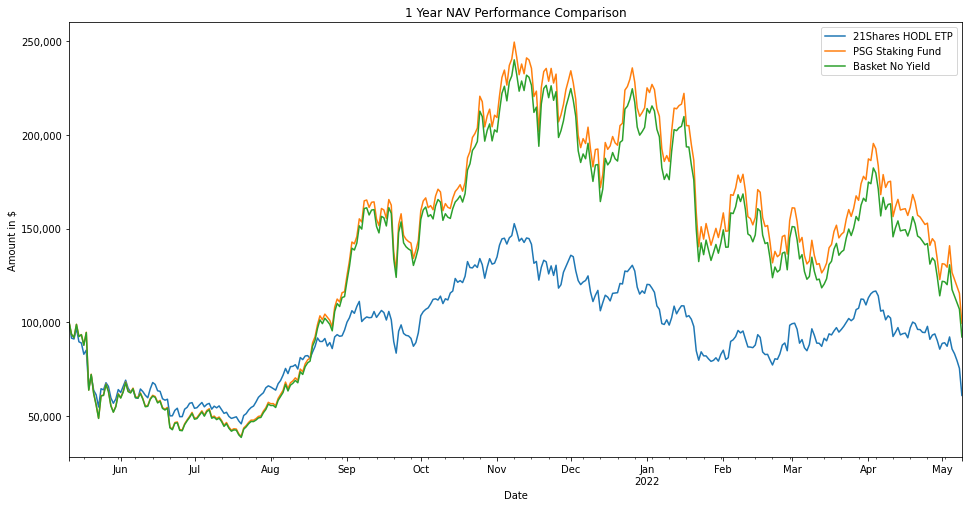

In [240]:
one_year_compare_df = pd.DataFrame(columns =['Date','21Shares HODL ETP','Basket No Yield','PSG Staking Fund'])

one_year_compare_df.set_index('Date',inplace=True)
one_year_compare_df['21Shares HODL ETP'] = one_yr_hodl_portfolio_df['ONE_YEAR_HODL_NAV']
one_year_compare_df['Basket No Yield'] = one_year_basket_portfolio_df['ONE_YR_BASKET_NAV']
one_year_compare_df['PSG Staking Fund'] = one_year_basket_staking_portfolio_df['ONE_YR_BASKET_WITH_STAKING']
pl = one_year_compare_df.plot(y=['21Shares HODL ETP','PSG Staking Fund','Basket No Yield'],figsize=(16,8),title='1 Year NAV Performance Comparison')
pl.set_ylabel('Amount in $')
#compare_df
# pd.concat([hodl_portfolio_df['HODL_NAV'],basket_luna_portfolio_df['LUNA_BASKET_NAV'],basket_portfolio_df['BASKET_NAV']])
# compare_df.columns =

# .plot(y=['BASKET_NAV','LUNA_BASKET_NAV','HODL_NAV'],figsize=(16,8),title='NAV Performance Comparison')
# # after plotting the data, format the labels
current_values = pl.get_yticks()
# # using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

## 10 Year Chart

In [57]:
ten_year_eth_df = pd.DataFrame(columns =['Date','ETH_AMNT','ETH_AMNT_YIELD','ETH_Daily_Rate'])
ten_year_eth_df['Date'] = pd.date_range(start=pd.datetime(2020, 12, 1), periods=3650, freq='D')
ten_year_eth_df.set_index('Date',inplace=True)
# temp_df['ETH_AMNT'] = basket_staking_portfolio_df['ETH_AMNT']
ten_year_eth_df['ETH_AMNT'] = 32
ten_year_eth_df['ETH'] = 2345.00
ten_year_eth_df['ETH_NET'] = ten_year_eth_df['ETH'] * ten_year_eth_df['ETH_AMNT']
ten_year_eth_df['Day_Count'] = 1
ten_year_eth_df['Day_Count_Cum'] = ten_year_eth_df['Day_Count'].cumsum()
ETH_ANNUAL_YIELD = 8.00 #4.37
ETH_ANNUAL_YIELD_PERCENTAGE = ETH_ANNUAL_YIELD / 100
ETH_DAILY_YIELD_PERCENTAGE = (1 + ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_ETH_YIELD_AMNT = ten_year_eth_df['ETH_AMNT'] * ETH_DAILY_YIELD_PERCENTAGE
ten_year_eth_df['ETH_Daily_Rate'] = INITIAL_DAILY_ETH_YIELD_AMNT
ten_year_eth_df['ETH_AMNT_YIELD'] = ten_year_eth_df['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (ten_year_eth_df['Day_Count_Cum'])
ten_year_eth_df['ETH_NET_YIELD'] = round(ten_year_eth_df['ETH_AMNT_YIELD'] * ten_year_eth_df['ETH'],2)


FOUR_ETH_ANNUAL_YIELD = 4.00 #4.37
FOUR_ETH_ANNUAL_YIELD_PERCENTAGE = FOUR_ETH_ANNUAL_YIELD / 100
FOUR_ETH_DAILY_YIELD_PERCENTAGE = (1 + FOUR_ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
FOUR_INITIAL_DAILY_ETH_YIELD_AMNT = ten_year_eth_df['ETH_AMNT'] * FOUR_ETH_DAILY_YIELD_PERCENTAGE
ten_year_eth_df['ETH_Daily_Rate_4'] = FOUR_INITIAL_DAILY_ETH_YIELD_AMNT
ten_year_eth_df['ETH_AMNT_YIELD_4'] = ten_year_eth_df['ETH_AMNT'] * (1 + FOUR_ETH_DAILY_YIELD_PERCENTAGE) ** (ten_year_eth_df['Day_Count_Cum'])
ten_year_eth_df['ETH_NET_YIELD_4'] = round(ten_year_eth_df['ETH_AMNT_YIELD_4'] * ten_year_eth_df['ETH'] ,2)

EIGHTEEN_ETH_ANNUAL_YIELD = 18.00 #4.37
EIGHTEEN_ETH_ANNUAL_YIELD_PERCENTAGE = EIGHTEEN_ETH_ANNUAL_YIELD / 100
EIGHTEEN_ETH_DAILY_YIELD_PERCENTAGE = (1 + EIGHTEEN_ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
EIGHTEEN_INITIAL_DAILY_ETH_YIELD_AMNT = ten_year_eth_df['ETH_AMNT'] * EIGHTEEN_ETH_DAILY_YIELD_PERCENTAGE
ten_year_eth_df['ETH_Daily_Rate_18'] = EIGHTEEN_INITIAL_DAILY_ETH_YIELD_AMNT
ten_year_eth_df['ETH_AMNT_YIELD_18'] = ten_year_eth_df['ETH_AMNT'] * (1 + EIGHTEEN_ETH_DAILY_YIELD_PERCENTAGE) ** (ten_year_eth_df['Day_Count_Cum'])
ten_year_eth_df['ETH_NET_YIELD_18'] = round(ten_year_eth_df['ETH_AMNT_YIELD_18'] * ten_year_eth_df['ETH'] ,2)

ten_year_eth_df

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,ETH_AMNT,ETH_AMNT_YIELD,ETH_Daily_Rate,ETH,ETH_NET,Day_Count,Day_Count_Cum,ETH_NET_YIELD,ETH_Daily_Rate_4,ETH_AMNT_YIELD_4,ETH_NET_YIELD_4,ETH_Daily_Rate_18,ETH_AMNT_YIELD_18,ETH_NET_YIELD_18
Date,,,,,,,,,,,,,,
2020-12-01,32,32.006748,0.006748,2345.0,75040.0,1,1,75055.82,0.003439,32.003439,75048.06,0.014514,32.014514,75074.04
2020-12-02,32,32.013497,0.006748,2345.0,75040.0,1,2,75071.65,0.003439,32.006878,75056.13,0.014514,32.029035,75108.09
2020-12-03,32,32.020248,0.006748,2345.0,75040.0,1,3,75087.48,0.003439,32.010317,75064.19,0.014514,32.043562,75142.15
2020-12-04,32,32.027000,0.006748,2345.0,75040.0,1,4,75103.32,0.003439,32.013757,75072.26,0.014514,32.058096,75176.24
2020-12-05,32,32.033754,0.006748,2345.0,75040.0,1,5,75119.15,0.003439,32.017197,75080.33,0.014514,32.072637,75210.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-11-24,32,69.027357,0.006748,2345.0,75040.0,1,3646,161869.15,0.003439,47.347462,111029.80,0.014514,167.179223,392035.28
2030-11-25,32,69.041913,0.006748,2345.0,75040.0,1,3647,161903.29,0.003439,47.352550,111041.73,0.014514,167.255050,392213.09
2030-11-26,32,69.056472,0.006748,2345.0,75040.0,1,3648,161937.43,0.003439,47.357638,111053.66,0.014514,167.330912,392390.99


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


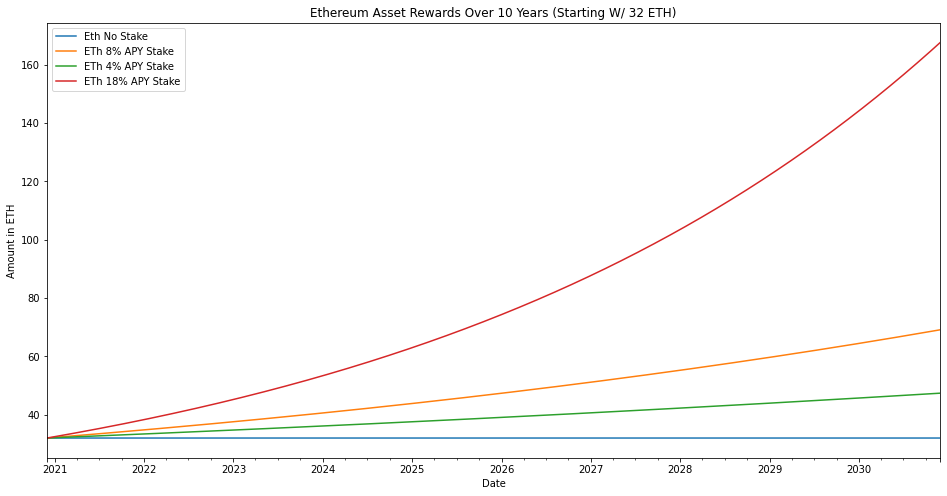

In [58]:
ten_year_eth_df.rename(columns = {'ETH_AMNT':'Eth No Stake', 'ETH_AMNT_YIELD':'ETh 8% APY Stake',
                         'ETH_AMNT_YIELD_4':'ETh 4% APY Stake',
                          'ETH_AMNT_YIELD_18':'ETh 18% APY Stake',
                         }, inplace = True)

pl = ten_year_eth_df.plot(y=['Eth No Stake','ETh 8% APY Stake','ETh 4% APY Stake','ETh 18% APY Stake'],figsize=(16,8),title='Ethereum Asset Rewards Over 10 Years (Starting W/ 32 ETH)')
pl.set_ylabel('Amount in ETH')

#compare_df
# pd.concat([hodl_portfolio_df['HODL_NAV'],basket_luna_portfolio_df['LUNA_BASKET_NAV'],basket_portfolio_df['BASKET_NAV']])
# compare_df.columns =

# .plot(y=['BASKET_NAV','LUNA_BASKET_NAV','HODL_NAV'],figsize=(16,8),title='NAV Performance Comparison')
# # after plotting the data, format the labels
current_values = pl.get_yticks()
# # using format string '{:.0f}' here but you can choose others
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


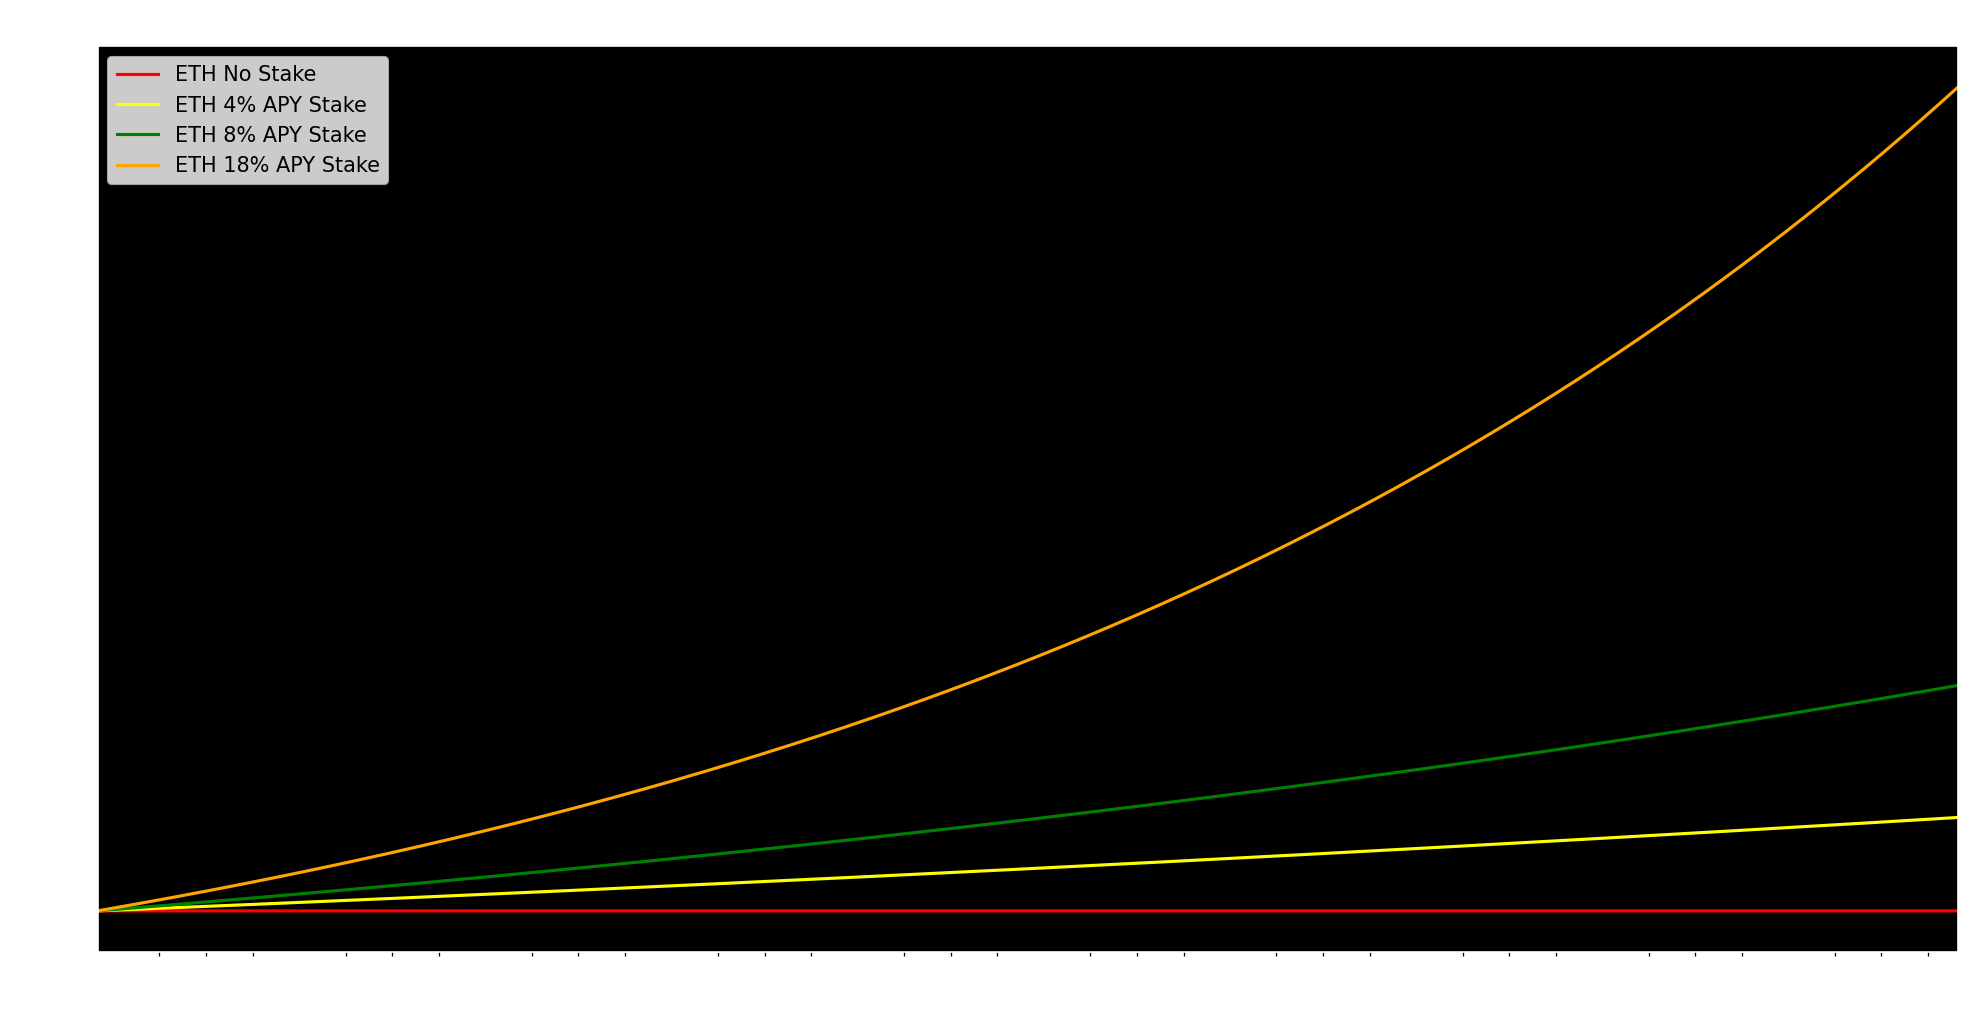

In [61]:
# RIGHT HERE



plt.figure(figsize=(16, 8), dpi=150)
ax = plt.axes()

ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.set_facecolor("black");
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.

#ten_year_eth_df.plot(y=['Eth No Stake','ETh 8% APY Stake','ETh 4% APY Stake','ETh 18% APY Stake']
ten_year_eth_df['Eth No Stake'].plot(label='ETH No Stake', color='red')
ten_year_eth_df['ETh 4% APY Stake'].plot(label='ETH 4% APY Stake', color='yellow')
ten_year_eth_df['ETh 8% APY Stake'].plot(label='ETH 8% APY Stake', color='green')
ten_year_eth_df['ETh 18% APY Stake'].plot(label='ETH 18% APY Stake', color='orange')
  
# adding title to the plot
plt.title('Ethereum Asset Rewards Over 10 Years (Starting W/ 32 ETH)',color="white")
  
# adding Label to the x-axis
plt.xlabel('Projected Time In 10 Years',color='white')
plt.ylabel('Amount in ETH',color='white')

current_values = ax.get_yticks()
# # using format string '{:.0f}' here but you can choose others
ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);
# adding legend to the curve
plt.legend()









/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


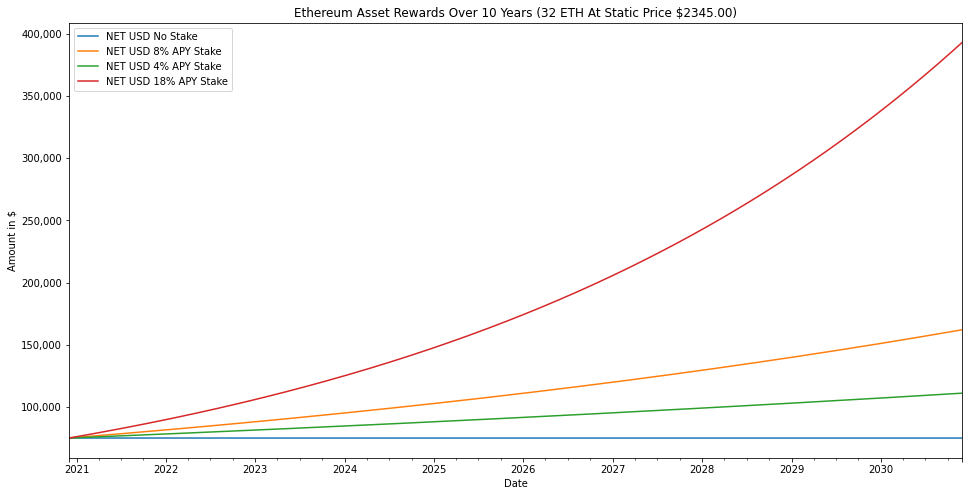

In [60]:
ten_year_eth_df.rename(columns = {'ETH_NET':'NET USD No Stake',
                          'ETH_NET_YIELD':'NET USD 8% APY Stake',
                         'ETH_NET_YIELD_4':'NET USD 4% APY Stake',
                          'ETH_NET_YIELD_18':'NET USD 18% APY Stake',
                         }, inplace = True)

pl = ten_year_eth_df.plot(y=['NET USD No Stake','NET USD 8% APY Stake','NET USD 4% APY Stake','NET USD 18% APY Stake'],figsize=(16,8),title='Ethereum Asset Rewards Over 10 Years (32 ETH At Static Price $2345.00)')
pl.set_ylabel('Amount in $')
current_values = pl.get_yticks()
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

In [266]:
ten_year_ftm_df = ten_year_eth_df.copy()


ten_year_ftm_df['FTM_AMNT'] = 500000
ten_year_ftm_df['FTM'] = 0.51
ten_year_ftm_df['FTM_NET'] = ten_year_ftm_df['FTM'] * ten_year_ftm_df['FTM_AMNT']
FTM_ANNUAL_YIELD = 14.19
FTM_ANNUAL_YIELD_PERCENTAGE = FTM_ANNUAL_YIELD / 100
FTM_DAILY_YIELD_PERCENTAGE = (1 + FTM_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_FTM_YIELD_AMNT = FTM_INIT_AMNT * FTM_DAILY_YIELD_PERCENTAGE
ten_year_ftm_df['FTM_Daily_Rate'] = FTM_DAILY_YIELD_PERCENTAGE
ten_year_ftm_df['FTM_AMNT_YIELD'] = ten_year_ftm_df['FTM_AMNT'] * (1 + FTM_DAILY_YIELD_PERCENTAGE) ** (ten_year_ftm_df['Day_Count_Cum'])
ten_year_ftm_df['FTM_NET_YIELD'] = round(ten_year_ftm_df['FTM_AMNT_YIELD'] * ten_year_ftm_df['FTM'],2)

ten_year_ftm_df


,Eth No Stake,ETh 8% APY Stake,ETH_Daily_Rate,ETH,NET USD No Stake,Day_Count,Day_Count_Cum,NET USD 8% APY Stake,ETH_Daily_Rate_4,ETh 4% APY Stake,NET USD 4% APY Stake,ETH_Daily_Rate_18,ETh 18% APY Stake,NET USD 18% APY Stake,FTM_AMNT,FTM,FTM_NET,FTM_Daily_Rate,FTM_AMNT_YIELD,FTM_NET_YIELD
Date,,,,,,,,,,,,,,,,,,,,
2020-12-01,32,32.006748,0.006748,2345.0,75040.0,1,1,75055.82,0.003439,32.003439,75048.06,0.014514,32.014514,75074.04,500000,0.51,255000.0,0.000364,5.001818e+05,255092.72
2020-12-02,32,32.013497,0.006748,2345.0,75040.0,1,2,75071.65,0.003439,32.006878,75056.13,0.014514,32.029035,75108.09,500000,0.51,255000.0,0.000364,5.003637e+05,255185.47
2020-12-03,32,32.020248,0.006748,2345.0,75040.0,1,3,75087.48,0.003439,32.010317,75064.19,0.014514,32.043562,75142.15,500000,0.51,255000.0,0.000364,5.005456e+05,255278.26
2020-12-04,32,32.027000,0.006748,2345.0,75040.0,1,4,75103.32,0.003439,32.013757,75072.26,0.014514,32.058096,75176.24,500000,0.51,255000.0,0.000364,5.007276e+05,255371.08
2020-12-05,32,32.033754,0.006748,2345.0,75040.0,1,5,75119.15,0.003439,32.017197,75080.33,0.014514,32.072637,75210.33,500000,0.51,255000.0,0.000364,5.009097e+05,255463.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030-11-24,32,69.027357,0.006748,2345.0,75040.0,1,3646,161869.15,0.003439,47.347462,111029.80,0.014514,167.179223,392035.28,500000,0.51,255000.0,0.000364,1.881998e+06,959819.06
2030-11-25,32,69.041913,0.006748,2345.0,75040.0,1,3647,161903.29,0.003439,47.352550,111041.73,0.014514,167.255050,392213.09,500000,0.51,255000.0,0.000364,1.882682e+06,960168.06
2030-11-26,32,69.056472,0.006748,2345.0,75040.0,1,3648,161937.43,0.003439,47.357638,111053.66,0.014514,167.330912,392390.99,500000,0.51,255000.0,0.000364,1.883367e+06,960517.19


/Users/dennismacpro/Cryptonomics/PSG/PSGQuantMonoRepo/psg-staking-models/psg-staking-models/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


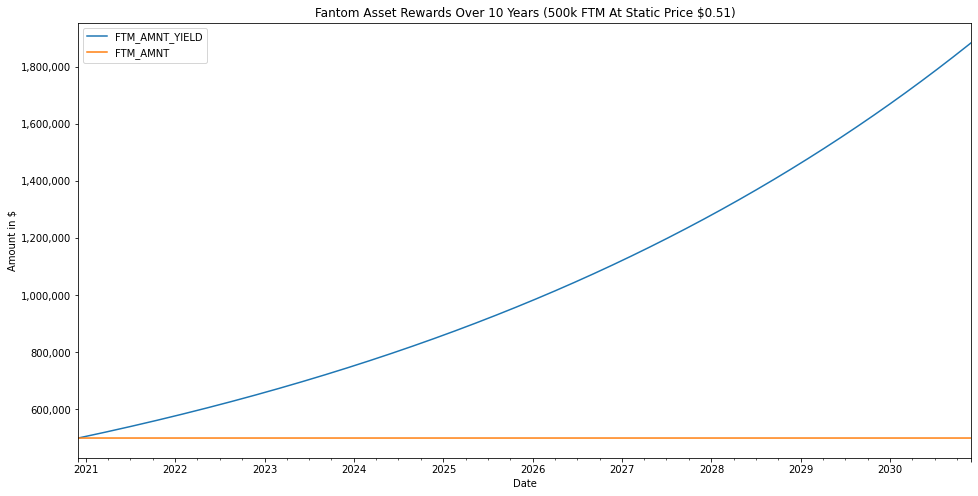

In [267]:
pl = ten_year_ftm_df.plot(y=['FTM_AMNT_YIELD','FTM_AMNT'],figsize=(16,8),title='Fantom Asset Rewards Over 10 Years (500k FTM At Static Price $0.51)')
pl.set_ylabel('Amount in $')
current_values = pl.get_yticks()
pl.set_yticklabels(['{:,.0f}'.format(x) for x in current_values]);

In [44]:
float(portfolio_df['LUNA_NET'].iloc[-1])

367220.97

In [45]:
round((float(portfolio_df['LUNA_NET'].iloc[-1]) - float(portfolio_df['LUNA_NET'].iloc[0])) / float(portfolio_df['LUNA_NET'].iloc[0]) * 100)

8685

In [46]:
## Calculate fixed staking rates and assume daily compound
x = 0.00011719067956206253
p = 1000
z = 1000
z1 = z

# A = the future value of the investment/loan, including interest
# P = the principal investment amount (the initial deposit or loan amount)
# r = the annual interest rate (decimal)
# n = the number of times that interest is compounded per unit t
# t = the time the money is invested or borrowed for

# so if i convert the annualized interested to daily then 
# i becomes 1 for daily because it is compounded 1/day per unit t which is a day so 
# day/day = 1
# https://www.thecalculatorsite.com/articles/finance/compound-interest-formula.php
# https://calculate.onl/expected-return-portfolio-calculator/
# https://numpy.org/numpy-financial/latest/


for i in range(0,366):
    z = z * (1+x)
    #print(f"z:{z}")
    a = p * (1 + x) ** (i)
    r = p * (((1+x) ** (i)) - 1)
    print(f"day:{i} a:{a}, r:{r}")




day:0 a:1000.0, r:0.0
day:1 a:1000.1171906795621, r:0.11719067956206253
day:2 a:1000.2343950927794, r:0.23439509277944914
day:3 a:1000.3516132412618, r:0.3516132412617612
day:4 a:1000.4688451266186, r:0.4688451266186
day:5 a:1000.5860907504596, r:0.5860907504595669
day:6 a:1000.7033501143949, r:0.7033501143949294
day:7 a:1000.8206232200349, r:0.820623220034955
day:8 a:1000.9379100689897, r:0.9379100689896891
day:9 a:1001.0552106628703, r:1.0552106628702873
day:10 a:1001.172525003287, r:1.1725250032870171
day:11 a:1001.289853091851, r:1.2898530918510343
day:12 a:1001.4071949301733, r:1.4071949301732722
day:13 a:1001.5245505198656, r:1.524550519865553
day:14 a:1001.641919862539, r:1.6419198625390319
day:15 a:1001.7593029598055, r:1.759302959805531
day:16 a:1001.8766998132771, r:1.876699813277094
day:17 a:1001.9941104245655, r:1.9941104245655428
day:18 a:1002.1115347952833, r:2.111534795283365
day:19 a:1002.2289729270431, r:2.228972927043049
day:20 a:1002.3464248214573, r:2.34642482145730

In [54]:
eth_yield_df = pd.concat([eth_df['Close'],portfolio_df['ETH_AMNT'],portfolio_df['ETH_NET'],],axis=1)
eth_yield_df.columns = ['ETH_CLOSE_PRICE','ETH_AMNT','ETH_NET']
ETH_ANNUAL_YIELD = 8.00 #4.37
ETH_ANNUAL_YIELD_PERCENTAGE = ETH_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
ETH_DAILY_YIELD_PERCENTAGE = (1 + ETH_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_ETH_YIELD_AMNT = ETH_INIT_AMNT * ETH_DAILY_YIELD_PERCENTAGE
print(ETH_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_ETH_YIELD_AMNT)
eth_yield_df['Daily_Rate'] = ETH_DAILY_YIELD_PERCENTAGE
eth_yield_df['Day_Count'] = 1
eth_yield_df['Day_Count_Cum'] = eth_yield_df['Day_Count'].cumsum()
eth_yield_df['ETH_AMNT_YIELD'] = eth_yield_df['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (eth_yield_df['Day_Count_Cum'])
#eth_yield_df['ETH_AMNT'] + (eth_yield_df['ETH_AMNT'] * eth_yield_df['Daily_Rate']).cumsum()
#eth_yield_df['ETH_AMNT_YIELD_2'] = eth_yield_df['ETH_AMNT'] * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (eth_yield_df['Day_Count_Cum'])
#p * (1 + x) ** (i)
#df["Principal"] = np.ppmt(Interest_Rate/Payments_Year, df.index, Years*Payments_Year, Principal)



eth_yield_df['ETH_NET_YIELD'] = round(eth_yield_df['ETH_AMNT_YIELD'] * eth_yield_df['ETH_CLOSE_PRICE'],2)
eth_yield_df 
# eth_yield_df['ETH_AMNT_YIELD'] = ETH_INIT_AMNT 
# eth_yield_df['ETH_DAILY_YIELD_PERCENTAGE'] = ETH_DAILY_YIELD_PERCENTAGE 
# eth_yield_df['ETH_AMNT_YIELD_CUM'] = ETH_INIT_AMNT * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (eth_yield_df.index)


# df['total'] = (df['deposit'] * df['rate'].shift().add(1).cumprod().fillna(1)).cumsum()
# eth_yield_df['ETH_AMNT_YIELD_CUM'] = ETH_INIT_AMNT * (1 + ETH_DAILY_YIELD_PERCENTAGE) ** (eth_yield_df.index)

#eth_yield_df['ETH_AMNT_YIELD_CUM'] = eth_yield_df['ETH_AMNT_YIELD'] + (eth_yield_df['ETH_AMNT_YIELD'] * ETH_DAILY_YIELD_PERCENTAGE)
#eth_yield_df['ETH_AMNT_YIELD_CUM_DIFF'] = eth_yield_df['ETH_AMNT_YIELD_CUM'] - eth_yield_df['ETH_AMNT_YIELD_CUM'].shift(1)
# eth_yield_df['ETH_AMNT_YIELD'] = ETH_INIT_AMNT
# eth_yield_df['ETH_AMNT_YIELD_CUM'] = eth_yield_df['ETH_AMNT_YIELD'].cumsum() + (eth_yield_df['ETH_AMNT_YIELD_CUM'].shift(1) * ETH_DAILY_YIELD_PERCENTAGE)
# eth_yield_df['ETH_NET_YIELD'] = round(eth_yield_df['ETH_AMNT_YIELD_CUM'] * eth_yield_df['ETH'],2)
# eth_yield_df


0.00021087439837685906
0.01787582275040634


,ETH_CLOSE_PRICE,ETH_AMNT,ETH_NET,Daily_Rate,Day_Count,Day_Count_Cum,ETH_AMNT_YIELD,ETH_NET_YIELD
Date,,,,,,,,
2020-12-01,589.814467,84.77,49998.57,0.000211,1,1,84.787876,50009.12
2020-12-02,598.357253,84.77,50722.74,0.000211,1,2,84.805755,50744.14
2020-12-03,616.904853,84.77,52295.02,0.000211,1,3,84.823639,52328.11
2020-12-04,571.978333,84.77,48486.60,0.000211,1,4,84.841526,48527.51
2020-12-05,595.548506,84.77,50484.65,0.000211,1,5,84.859417,50537.90
...,...,...,...,...,...,...,...,...
2022-04-27,2893.559731,84.77,245287.06,0.000211,1,513,94.453615,273307.18
2022-04-28,2938.545100,84.77,249100.47,0.000211,1,514,94.473533,277614.74
2022-04-29,2817.726674,84.77,238858.69,0.000211,1,515,94.493455,266256.73


In [55]:
float(eth_yield_df['ETH_NET'].iloc[-1])

240050.52

In [56]:
float(eth_yield_df['ETH_NET_YIELD'].iloc[-1])

267698.14

In [57]:
round(float(eth_yield_df['ETH_AMNT_YIELD'].iloc[-1])- float(eth_yield_df['ETH_AMNT'].iloc[-1]),2)

9.76

In [58]:
round(11995925.660000026 * float(eth_yield_df['ETH_CLOSE_PRICE'].iloc[-1]),2)

33969897939.81

In [59]:
amount = eth_yield_df['ETH_AMNT_YIELD'].iloc[-1] - eth_yield_df['ETH_AMNT_YIELD'].iloc[0]
value_current_price = amount * eth_yield_df['ETH_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(10, '$27,596.99')

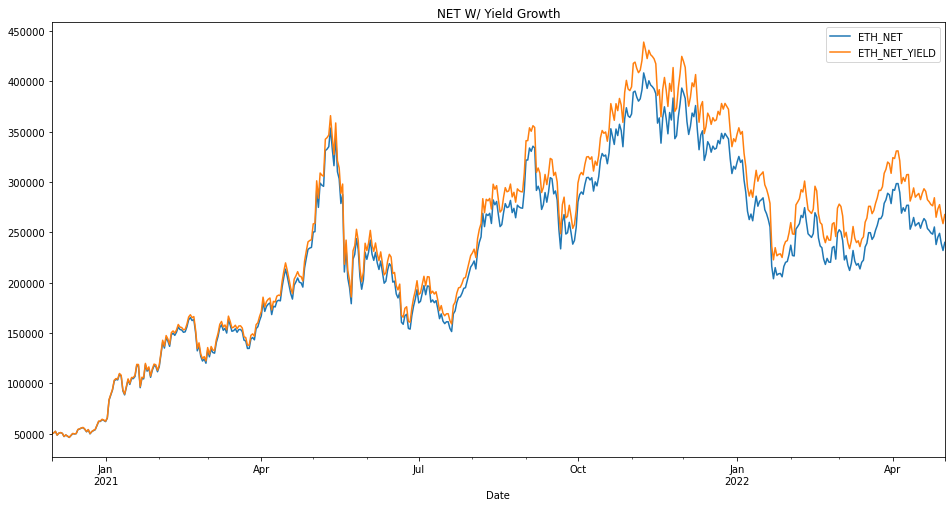

In [60]:
pl = eth_yield_df.plot(y=['ETH_NET','ETH_NET_YIELD'],figsize=(16,8),title='NET W/ Yield Growth')

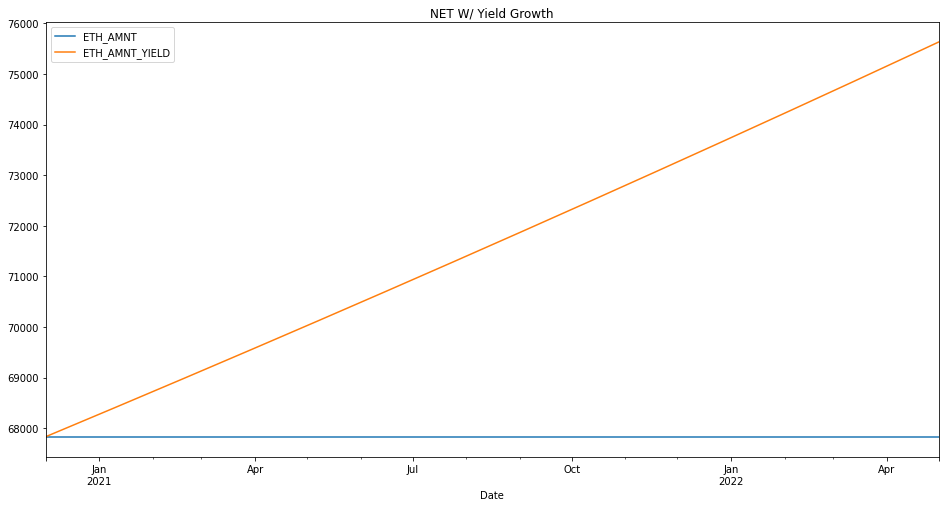

In [38]:
pl = eth_yield_df.plot(y=['ETH_AMNT','ETH_AMNT_YIELD'],figsize=(16,8),title='NET W/ Yield Growth')

In [40]:
sol_yield_df = pd.concat([sol_df['Close'],portfolio_df['SOL_AMNT'],portfolio_df['SOL_NET'],],axis=1)
sol_yield_df.columns = ['SOL_CLOSE_PRICE','SOL_AMNT','SOL_NET']
SOL_ANNUAL_YIELD = 5.75
SOL_ANNUAL_YIELD_PERCENTAGE = SOL_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
SOL_DAILY_YIELD_PERCENTAGE = (1 + SOL_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_SOL_YIELD_AMNT = SOL_INIT_AMNT * SOL_DAILY_YIELD_PERCENTAGE
print(SOL_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_SOL_YIELD_AMNT)
sol_yield_df['Daily_Rate'] = SOL_DAILY_YIELD_PERCENTAGE
sol_yield_df['Day_Count'] = 1
sol_yield_df['Day_Count_Cum'] = sol_yield_df['Day_Count'].cumsum()
sol_yield_df['SOL_AMNT_YIELD'] = sol_yield_df['SOL_AMNT'] * (1 + SOL_DAILY_YIELD_PERCENTAGE) ** (sol_yield_df['Day_Count_Cum'])

#sol_yield_df['SOL_AMNT_YIELD'] = sol_yield_df['SOL_AMNT'] + (sol_yield_df['SOL_AMNT'] * sol_yield_df['Daily_Rate']).cumsum()
sol_yield_df['SOL_NET_YIELD'] = round(sol_yield_df['SOL_AMNT_YIELD'] * sol_yield_df['SOL_CLOSE_PRICE'],2)
sol_yield_df 

0.00015318332571911952
1936.5624452901725


,SOL_CLOSE_PRICE,SOL_AMNT,SOL_NET,Daily_Rate,Day_Count,Day_Count_Cum,SOL_AMNT_YIELD,SOL_NET_YIELD
Date,,,,,,,,
2020-12-01,1.977516,12642123,2.500000e+07,0.000153,1,1,1.264406e+07,2.500383e+07
2020-12-02,2.112355,12642123,2.670465e+07,0.000153,1,2,1.264600e+07,2.671283e+07
2020-12-03,2.098405,12642123,2.652829e+07,0.000153,1,3,1.264793e+07,2.654049e+07
2020-12-04,1.856668,12642123,2.347223e+07,0.000153,1,4,1.264987e+07,2.348662e+07
2020-12-05,1.977440,12642123,2.499904e+07,0.000153,1,5,1.265181e+07,2.501819e+07
...,...,...,...,...,...,...,...,...
2022-04-27,98.309653,12642123,1.242843e+09,0.000153,1,513,1.367557e+07,1.344441e+09
2022-04-28,98.129000,12642123,1.240559e+09,0.000153,1,514,1.367767e+07,1.342176e+09
2022-04-29,93.942711,12642123,1.187635e+09,0.000153,1,515,1.367976e+07,1.285114e+09


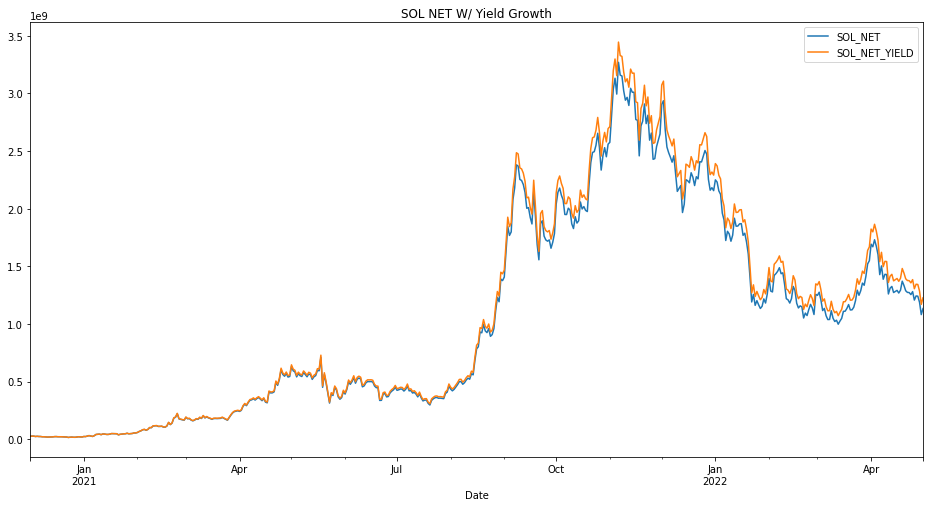

In [41]:
pl = sol_yield_df.plot(y=['SOL_NET','SOL_NET_YIELD'],figsize=(16,8),title='SOL NET W/ Yield Growth')

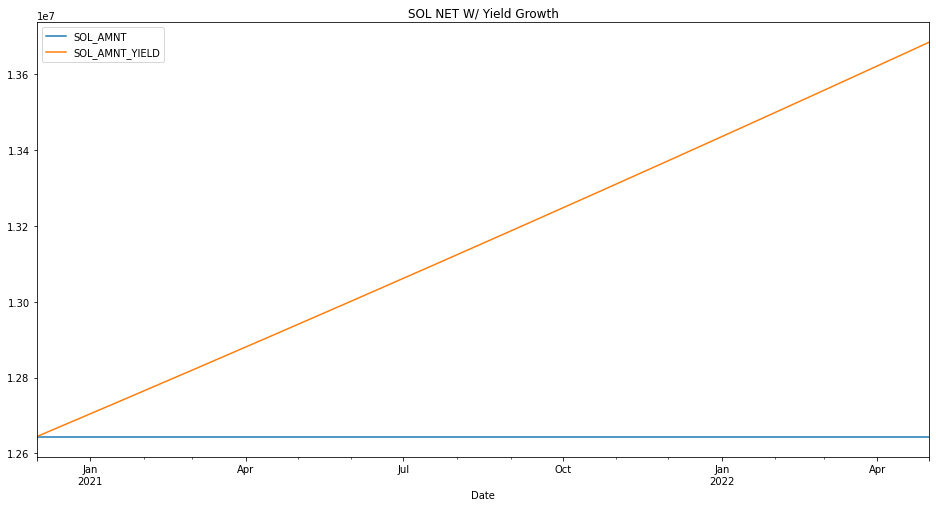

In [42]:
pl = sol_yield_df.plot(y=['SOL_AMNT','SOL_AMNT_YIELD'],figsize=(16,8),title='SOL NET W/ Yield Growth')

In [43]:
# Amount of SOL gained by staking....
amount = sol_yield_df['SOL_AMNT_YIELD'].iloc[-1] - sol_yield_df['SOL_AMNT_YIELD'].iloc[0]
value_current_price = amount * sol_yield_df['SOL_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(1039896, '$93,237,005.79')

In [19]:
near_yield_df = pd.concat([near_df['Close'],portfolio_df['NEAR_AMNT'],portfolio_df['NEAR_NET'],],axis=1)
near_yield_df.columns = ['NEAR_CLOSE_PRICE','NEAR_AMNT','NEAR_NET']
NEAR_ANNUAL_YIELD = 10
NEAR_ANNUAL_YIELD_PERCENTAGE = NEAR_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
NEAR_DAILY_YIELD_PERCENTAGE = (1 + NEAR_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_NEAR_YIELD_AMNT = NEAR_INIT_AMNT * NEAR_DAILY_YIELD_PERCENTAGE
print(NEAR_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_NEAR_YIELD_AMNT)
near_yield_df['Daily_Rate'] = NEAR_DAILY_YIELD_PERCENTAGE

near_yield_df['Day_Count'] = 1
near_yield_df['Day_Count_Cum'] = near_yield_df['Day_Count'].cumsum()
near_yield_df['NEAR_AMNT_YIELD'] = near_yield_df['NEAR_AMNT'] * (1 + NEAR_DAILY_YIELD_PERCENTAGE) ** (near_yield_df['Day_Count_Cum'])
#near_yield_df['NEAR_AMNT_YIELD'] = near_yield_df['NEAR_AMNT'] + (near_yield_df['NEAR_AMNT'] * near_yield_df['Daily_Rate']).cumsum()
near_yield_df['NEAR_NET_YIELD'] = round(near_yield_df['NEAR_AMNT_YIELD'] * near_yield_df['NEAR_CLOSE_PRICE'],2)
near_yield_df

0.00026115787606784124
0.12143841237154618


,NEAR_CLOSE_PRICE,NEAR_AMNT,NEAR_NET,Daily_Rate,Day_Count,Day_Count_Cum,NEAR_AMNT_YIELD,NEAR_NET_YIELD
Date,,,,,,,,
2020-12-01,1.075536,465,500.12,0.000261,1,1,465.121438,500.25
2020-12-02,1.176352,465,547.00,0.000261,1,2,465.242909,547.29
2020-12-03,1.155287,465,537.21,0.000261,1,3,465.364410,537.63
2020-12-04,1.106827,465,514.67,0.000261,1,4,465.485944,515.21
2020-12-05,1.111261,465,516.74,0.000261,1,5,465.607509,517.41
...,...,...,...,...,...,...,...,...
2022-04-27,12.821237,465,5961.88,0.000261,1,513,531.654533,6816.47
2022-04-28,12.390900,465,5761.77,0.000261,1,514,531.793379,6589.40
2022-04-29,11.238076,465,5225.71,0.000261,1,515,531.932261,5977.90


In [20]:
# Amount of NEAR gained by staking....
amount = near_yield_df['NEAR_AMNT_YIELD'].iloc[-1] - near_yield_df['NEAR_AMNT_YIELD'].iloc[0]
value_current_price = amount * near_yield_df['NEAR_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(67, '$797.82')

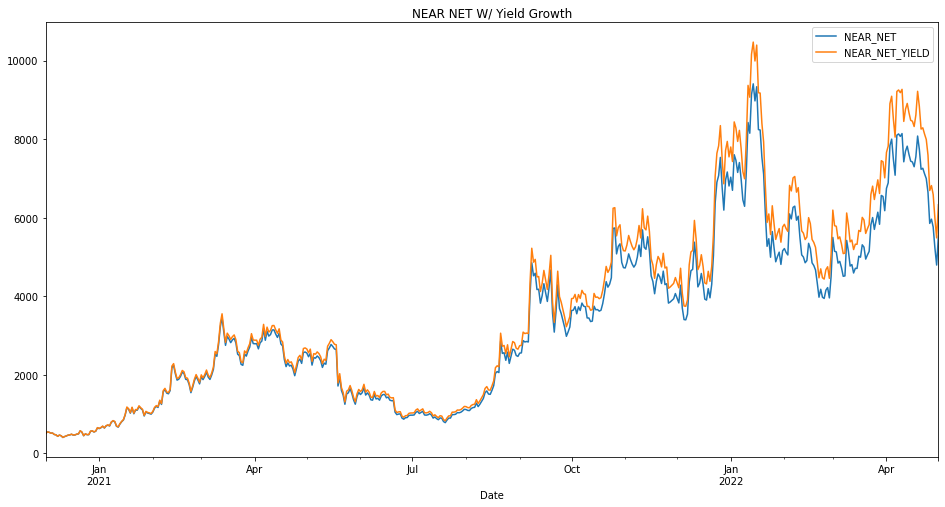

In [21]:
pl = near_yield_df.plot(y=['NEAR_NET','NEAR_NET_YIELD'],figsize=(16,8),title='NEAR NET W/ Yield Growth')

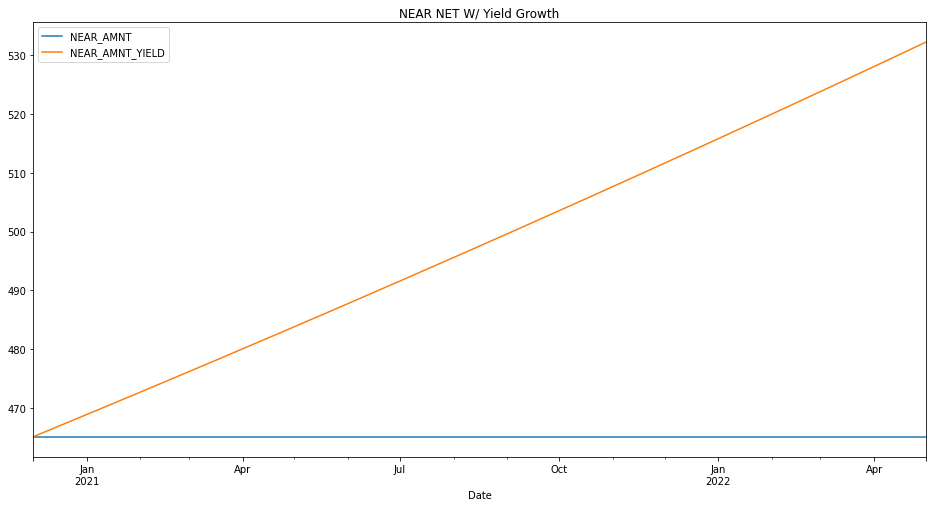

In [22]:
pl = near_yield_df.plot(y=['NEAR_AMNT','NEAR_AMNT_YIELD'],figsize=(16,8),title='NEAR NET W/ Yield Growth')

In [49]:
ftm_yield_df = pd.concat([ftm_df['Close'],portfolio_df['FTM_AMNT'],portfolio_df['FTM_NET'],],axis=1)
ftm_yield_df.columns = ['FTM_CLOSE_PRICE','FTM_AMNT','FTM_NET']
FTM_ANNUAL_YIELD = 14.19
FTM_ANNUAL_YIELD_PERCENTAGE = FTM_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
FTM_DAILY_YIELD_PERCENTAGE = (1 + FTM_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_FTM_YIELD_AMNT = FTM_INIT_AMNT * FTM_DAILY_YIELD_PERCENTAGE
print(FTM_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_FTM_YIELD_AMNT)
ftm_yield_df['Daily_Rate'] = FTM_DAILY_YIELD_PERCENTAGE
ftm_yield_df['Day_Count'] = 1
ftm_yield_df['Day_Count_Cum'] = ftm_yield_df['Day_Count'].cumsum()
ftm_yield_df['FTM_AMNT_YIELD'] = ftm_yield_df['FTM_AMNT'] * (1 + FTM_DAILY_YIELD_PERCENTAGE) ** (ftm_yield_df['Day_Count_Cum'])
#ftm_yield_df['FTM_AMNT_YIELD'] = ftm_yield_df['FTM_AMNT'] + (ftm_yield_df['FTM_AMNT'] * ftm_yield_df['Daily_Rate']).cumsum()
ftm_yield_df['FTM_NET_YIELD'] = round(ftm_yield_df['FTM_AMNT_YIELD'] * ftm_yield_df['FTM_CLOSE_PRICE'],2)
ftm_yield_df

0.0003636100400432607
88516.26639957547


,FTM_CLOSE_PRICE,FTM_AMNT,FTM_NET,Daily_Rate,Day_Count,Day_Count_Cum,FTM_AMNT_YIELD,FTM_NET_YIELD
Date,,,,,,,,
2020-12-01,0.020539,243437355,5.000000e+06,0.000364,1,1,2.435259e+08,5.001818e+06
2020-12-02,0.022646,243437355,5.512987e+06,0.000364,1,2,2.436144e+08,5.516997e+06
2020-12-03,0.022888,243437355,5.571880e+06,0.000364,1,3,2.437030e+08,5.577961e+06
2020-12-04,0.021042,243437355,5.122469e+06,0.000364,1,4,2.437916e+08,5.129923e+06
2020-12-05,0.022497,243437355,5.476639e+06,0.000364,1,5,2.438803e+08,5.486603e+06
...,...,...,...,...,...,...,...,...
2022-04-27,0.986282,243437355,2.400979e+08,0.000364,1,513,2.933474e+08,2.893233e+08
2022-04-28,0.968966,243437355,2.358825e+08,0.000364,1,514,2.934541e+08,2.843470e+08
2022-04-29,0.832615,243437355,2.026895e+08,0.000364,1,515,2.935608e+08,2.444230e+08


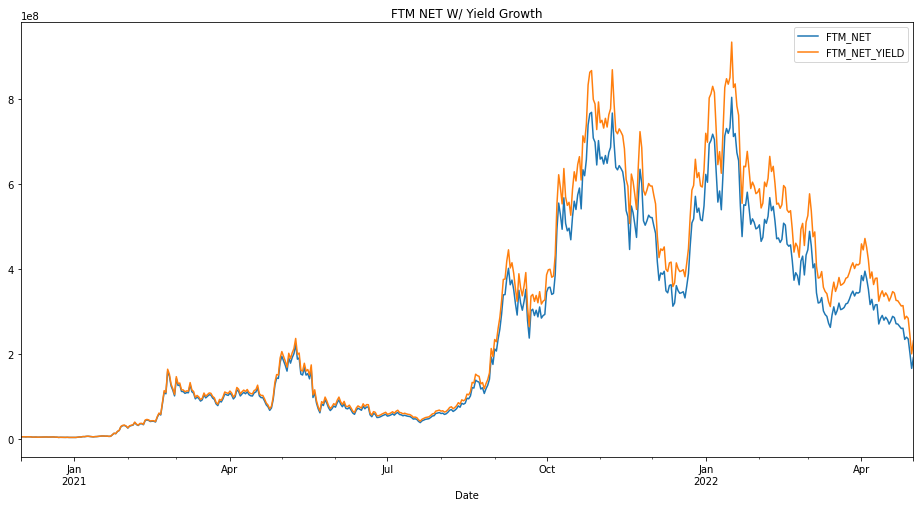

In [50]:
pl = ftm_yield_df.plot(y=['FTM_NET','FTM_NET_YIELD'],figsize=(16,8),title='FTM NET W/ Yield Growth')

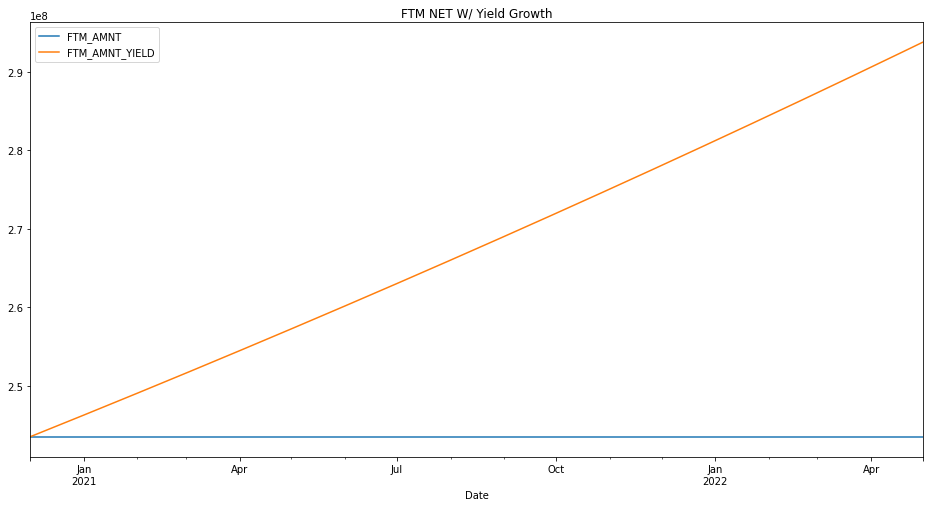

In [51]:
pl = ftm_yield_df.plot(y=['FTM_AMNT','FTM_AMNT_YIELD'],figsize=(16,8),title='FTM NET W/ Yield Growth')

In [54]:
# Amount of FTM gained by staking....
amount = ftm_yield_df['FTM_AMNT_YIELD'].iloc[-1] - ftm_yield_df['FTM_AMNT_YIELD'].iloc[0] 
value_current_price = amount * ftm_yield_df['FTM_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(50248451, '$39,611,959.49')

In [56]:
luna_yield_df = pd.concat([luna_df['Close'],portfolio_df['LUNA_AMNT'],portfolio_df['LUNA_NET'],],axis=1)
luna_yield_df.columns = ['LUNA_CLOSE_PRICE','LUNA_AMNT','LUNA_NET']
LUNA_ANNUAL_YIELD = 10.00
LUNA_ANNUAL_YIELD_PERCENTAGE = LUNA_ANNUAL_YIELD / 100
#i_daily = (1 + i_annual) ^ (1/365) – 1
LUNA_DAILY_YIELD_PERCENTAGE = (1 + LUNA_ANNUAL_YIELD_PERCENTAGE) ** (1/365) - 1
INITIAL_DAILY_LUNA_YIELD_AMNT = LUNA_INIT_AMNT * LUNA_DAILY_YIELD_PERCENTAGE
print(LUNA_DAILY_YIELD_PERCENTAGE)
print(INITIAL_DAILY_LUNA_YIELD_AMNT)
luna_yield_df['Daily_Rate'] = LUNA_DAILY_YIELD_PERCENTAGE
luna_yield_df['Day_Count'] = 1
luna_yield_df['Day_Count_Cum'] = luna_yield_df['Day_Count'].cumsum()
luna_yield_df['LUNA_AMNT_YIELD'] = luna_yield_df['LUNA_AMNT'] * (1 + LUNA_DAILY_YIELD_PERCENTAGE) ** (luna_yield_df['Day_Count_Cum'])

#luna_yield_df['LUNA_AMNT_YIELD'] = luna_yield_df['LUNA_AMNT'] + (luna_yield_df['LUNA_AMNT'] * luna_yield_df['Daily_Rate']).cumsum()
luna_yield_df['LUNA_NET_YIELD'] = round(luna_yield_df['LUNA_AMNT_YIELD'] * luna_yield_df['LUNA_CLOSE_PRICE'],2)
luna_yield_df

0.00026115787606784124
8742.929249007348


,LUNA_CLOSE_PRICE,LUNA_AMNT,LUNA_NET,Daily_Rate,Day_Count,Day_Count_Cum,LUNA_AMNT_YIELD,LUNA_NET_YIELD
Date,,,,,,,,
2020-12-01,0.388320,33477563,1.300000e+07,0.000261,1,1,3.348631e+07,1.300340e+07
2020-12-02,0.406310,33477563,1.360227e+07,0.000261,1,2,3.349505e+07,1.360938e+07
2020-12-03,0.506414,33477563,1.695351e+07,0.000261,1,3,3.350380e+07,1.696679e+07
2020-12-04,0.451015,33477563,1.509888e+07,0.000261,1,4,3.351255e+07,1.511466e+07
2020-12-05,0.509040,33477563,1.704143e+07,0.000261,1,5,3.352130e+07,1.706370e+07
...,...,...,...,...,...,...,...,...
2022-04-27,89.065569,33477563,2.981698e+09,0.000261,1,513,3.827634e+07,3.409104e+09
2022-04-28,88.665600,33477563,2.968308e+09,0.000261,1,514,3.828634e+07,3.394681e+09
2022-04-29,84.902554,33477563,2.842331e+09,0.000261,1,515,3.829634e+07,3.251457e+09


In [57]:
# Amount of LUNA gained by staking....
amount = luna_yield_df['LUNA_AMNT_YIELD'].iloc[-1] - luna_yield_df['LUNA_AMNT_YIELD'].iloc[0] 
value_current_price = amount * luna_yield_df['LUNA_CLOSE_PRICE'].iloc[-1]
round(amount), "$"+"{:,.2f}".format(round(value_current_price,2))

(4830034, '$397,372,249.44')

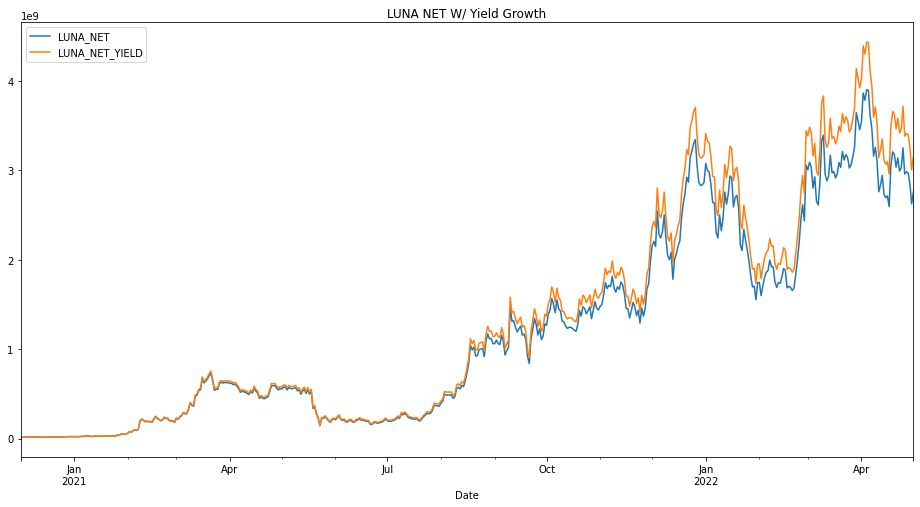

In [58]:
pl = luna_yield_df.plot(y=['LUNA_NET','LUNA_NET_YIELD'],figsize=(16,8),title='LUNA NET W/ Yield Growth')

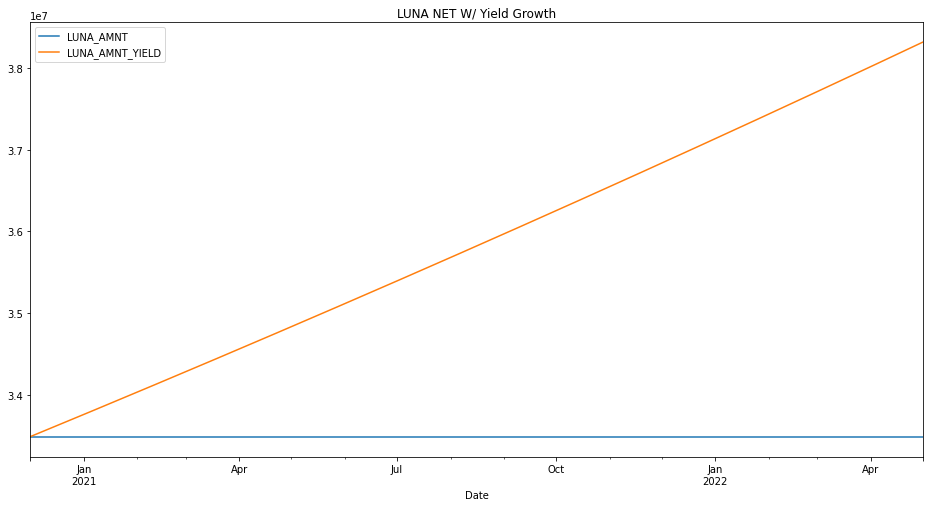

In [59]:
pl = luna_yield_df.plot(y=['LUNA_AMNT','LUNA_AMNT_YIELD'],figsize=(16,8),title='LUNA NET W/ Yield Growth')